<a href="https://colab.research.google.com/github/schokoro/AttentionNMT/blob/dev/en_jap_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Первым делом проверим какая карточка нам досталась. Лучшим вариантом будет `Tesla P100-PCIE-16GB`, на остальных будет считаться медленнее.

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    raise RuntimeErrorx
else:
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [2]:
!pip install janome pandarallel  > /dev/null

In [3]:
from typing import Dict, List, Optional
import torch.nn as nn

from torchtext.data import Field, BucketIterator
from tqdm.notebook import tqdm
from pandarallel import pandarallel
import torchtext
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import spacy
import warnings
import re
import random
import math
import time
from janome.tokenizer import Tokenizer as JTokenizer
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
tqdm.pandas()
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=False)

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Подготовка данных и EDA

Для обучения англо-японского переводчика будем использовать [Tanaka Corpus](http://www.edrdg.org/wiki/index.php/Tanaka_Corpus). Прямая ссылка на скачивание [здесь](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz).


In [5]:
!wget -q ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz 
!gunzip -f examples.utf.gz

## Подготовка корпуса

Посмотрим, как выглядит корпус:

In [6]:
!head -4 examples.utf

A: ムーリエルは２０歳になりました。	Muiriel is 20 now.#ID=1282_4707
B: は 二十歳(はたち){２０歳} になる[01]{になりました}
A: すぐに戻ります。	I will be back soon.#ID=1284_4709
B: 直ぐに{すぐに} 戻る{戻ります}


Нам нужны только строки с префиксом `A:`
Для токенизации английского языка будем использовать spacy, для японского - токенизатор janome. Для англо-японского перевода будет лучше, если японский текст мы развернём задом наперёд. Просто поверьте. Или можете проверить. Соответственно, при переводе нам будет необходимо развернуть переведённый текст обратно.

In [7]:
nlp = spacy.load("en_core_web_sm")
jt = JTokenizer()
en_remove = re.compile(r'#ID=.+')
is_token = re.compile(r'\w+')


def get_pair(line: str) -> Dict[str, str]:
    """
    Принимает на вход строку из файла паралелльного корпуса, возвращает словарь
     с японским и английским предложениями
    """
    jap, en = line.strip().split('\t')
    jap = jap.replace('A: ', '').strip()
    en = en_remove.sub('', en)
    return {'en': en, 'jap': jap}
  
def src_tokenize(text: str) -> List[str]:
    """
    Токенизирует английский текст, возвращает список токенов.
    """
    return [tok.text for tok in nlp.tokenizer(text)]


def trg_tokenize(text: str) -> List[str]:
    """
    Токенизирует японский текст, возвращает список токенов в обратном порядке
    """
    return [token.base_form for token in jt.tokenize(text)][: : -1]  # if is_token.match(token.base_form)


dicts = []
with open('examples.utf', 'r') as fobj:
    for i, line in enumerate(fobj):
        if line.startswith('A:'):
            dicts.append(get_pair(line))



corpus_df = pd.DataFrame(dicts)   

Посчитаем длины предложений в символах и посмотрим их корреляцию.

In [8]:
corpus_df['en_len'] = corpus_df['en'].map(lambda x: len(x))
corpus_df['jap_len'] = corpus_df['jap'].map(lambda x: len(x))

In [9]:
corpus_df[['en_len','jap_len' ]].corr()

,en_len,jap_len
en_len,1.000000,0.809457
jap_len,0.809457,1.000000


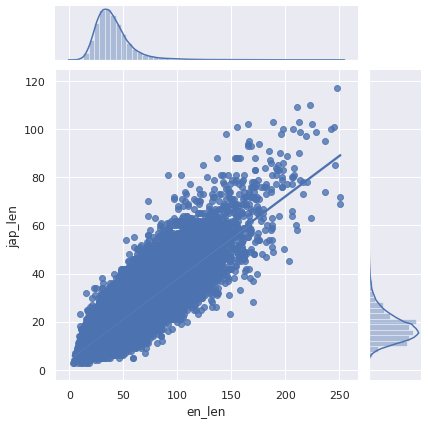

In [10]:
sns.jointplot("en_len", "jap_len", data=corpus_df, kind="reg");

А теперь - длины предложений в токенах и их корреляцию.

In [11]:
%time corpus_df['en_tok_len'] = corpus_df['en'].parallel_apply(lambda x: len(src_tokenize(x)))

CPU times: user 53.3 ms, sys: 84.1 ms, total: 137 ms
Wall time: 5.98 s


In [12]:
%time corpus_df['jap_tok_len'] = corpus_df['jap'].parallel_apply(lambda x: len(trg_tokenize(x)))

CPU times: user 104 ms, sys: 110 ms, total: 213 ms
Wall time: 2min 27s


In [13]:
corpus_df[['en_tok_len','jap_tok_len' ]].corr()

,en_tok_len,jap_tok_len
en_tok_len,1.000000,0.775549
jap_tok_len,0.775549,1.000000


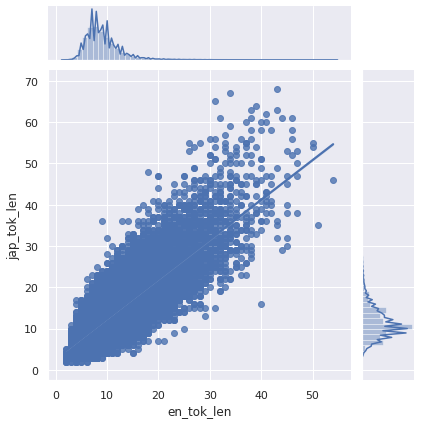

In [14]:
sns.jointplot("en_tok_len", "jap_tok_len", data=corpus_df, kind="reg")

In [15]:
corpus_df.describe()

,en_len,jap_len,en_tok_len,jap_tok_len
count,149791.000000,149791.000000,149791.000000,149791.000000
mean,40.471270,18.378407,9.307989,11.744270
std,17.417855,7.237879,3.594693,4.449102
min,3.000000,3.000000,2.000000,2.000000
25%,29.000000,14.000000,7.000000,9.000000
50%,37.000000,17.000000,9.000000,11.000000
75%,47.000000,21.000000,11.000000,14.000000
max,251.000000,117.000000,54.000000,68.000000


Выбросим из корпуса предложения длиннее чем `quantile(0.9)` и сохраним в файл.

In [16]:
corpus_df.en_tok_len.quantile(0.9), corpus_df.jap_tok_len.quantile(0.9)

(13.0, 17.0)

In [17]:
new_corpus_df = corpus_df[
    (corpus_df.en_tok_len < corpus_df.en_tok_len.quantile(0.9)) &
    (corpus_df.jap_tok_len < corpus_df.jap_tok_len.quantile(0.9)) 
]
corpus_df.shape

(149791, 6)

In [18]:
new_corpus_df.to_csv('en_jap_corpus.csv', index=None, columns=['en', 'jap'])

In [19]:
max_src = corpus_df.en_tok_len.max() + 2
max_trg = corpus_df.jap_tok_len.max() + 2

In [20]:
SRC = Field(
            tokenize = src_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(
            tokenize = trg_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [21]:
%%time
trn_data_fields = [("src", SRC), ("trg", TRG)]

dataset = torchtext.data.TabularDataset(
    path='en_jap_corpus.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)



CPU times: user 2min 24s, sys: 520 ms, total: 2min 24s
Wall time: 2min 24s


In [22]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [23]:
SRC.build_vocab(train_data.src, min_freq=3)  # 
print(SRC.vocab.freqs.most_common(10))

TRG.build_vocab(train_data.trg, min_freq=3)
print(TRG.vocab.freqs.most_common(10))


print(f'SRC.vocab: {len(SRC.vocab)}, TRG.vocab: {len(TRG.vocab)}')

[('.', 110945), ('the', 47508), ('to', 26425), ('i', 25461), ('a', 21923), ('is', 20993), ('he', 19826), ('you', 15670), ('of', 14218), ('in', 13554)]
[('。', 121263), ('は', 93010), ('た', 51259), ('の', 48574), ('に', 48356), ('を', 47677), ('て', 34193), ('が', 30261), ('する', 27333), ('だ', 25724)]
SRC.vocab: 9050, TRG.vocab: 11167


In [24]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    shuffle=True,
    device=device)

## Training the Transformer Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [32]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2 * HID_DIM
DEC_PF_DIM = 2 * HID_DIM
ENC_DROPOUT = 0.07
DEC_DROPOUT = 0.07

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              EncoderLayer, 
              MultiHeadAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              ENC_DROPOUT, 
              device,
              max_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DecoderLayer, 
              MultiHeadAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              DEC_DROPOUT, 
              device,
              max_trg)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [33]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
try:
    del model
    torch.cuda.empty_cache()
except:
    print('no model')

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model = Transformer()

no model


We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [34]:


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,035,935 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [37]:
def evaluate_blue(ev_data=valid_data):
    n_gram_weights = [1 / 3] * 3

    test_len = len(ev_data)

    original_texts = []
    generated_texts = []
    macro_bleu = 0

    for example_idx in range(test_len):
        src = vars(ev_data.examples[example_idx])['src']
        trg = vars(ev_data.examples[example_idx])['trg']
        translation, _ = translate_sentence(src, SRC, TRG, model, device)

        original_texts.append(trg)
        generated_texts.append(translation)

        bleu_score = nltk.translate.bleu_score.sentence_bleu(
            [trg[::-1]],  # 
            translation[: -1],
            weights = n_gram_weights
        )    
        macro_bleu += bleu_score
    macro_bleu /= test_len

    return macro_bleu


In [38]:
def train(model, iterator, optimizer, criterion, clip, limit: Optional[float]=1, accumulation_steps=1):
    
    model.train()

    epoch_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(iterator):

        if i / len(iterator) > limit:
            break
        
        src = batch.src
        trg = batch.trg
        
        output, _ = model(src, trg[:,:-1])  # 
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        epoch_loss += loss.item()

        loss /=  accumulation_steps
        loss.backward()
        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()                            # Now we can do an optimizer step
            model.zero_grad()        
    optimizer.step()    
        
        
    return epoch_loss / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
         for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


We then define a small function that we can use to tell us how long an epoch takes.

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
model.apply(initialize_weights);
best_macro_bleu = 0
test_loss = np.inf

In [42]:
BEST_MODEL = 'best_blue_en_jap.pt'

In [43]:
# cross_entropy = CrossEntropyLoss(ignore_index = TRG_PAD_IDX, smooth_eps=0.03)
cross_entropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
LEARNING_RATE = 1.25e-3
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

def criterion(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return cross_entropy(pred_flat, target_flat)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.2,
                                                       verbose=True,
                                                       cooldown=0, 
                                                       patience=4,              
                                                       threshold=0.01,
                                                       min_lr=5e-5)

In [44]:
# train(model, train_iterator, optimizer, criterion, CLIP, 128)
train_history = []
valid_history = []
blue_history = []

In [45]:
N_EPOCHS = 40
CLIP = 1

try:
    best_valid_loss = evaluate(model, valid_iterator, criterion)
except:
    best_valid_loss = float('inf')
print(f'Loss: {best_valid_loss:7.3f}')


for epoc_num, epoch in tqdm(enumerate(range(N_EPOCHS)), total=N_EPOCHS):
    curent_lr = optimizer.param_groups[0]['lr']
    start_time = time.time()
    try:
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 1, 1)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        scheduler.step(valid_loss)
                
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print('Новая лучшая модель')

        macro_bleu = evaluate_blue()
        if macro_bleu > best_macro_bleu:
            best_macro_bleu = macro_bleu
            print('Новый лучший blue')            
            torch.save(model.state_dict(), BEST_MODEL)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        blue_history.append(macro_bleu)

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        
        print(f'\tMacro-average BLEU: {macro_bleu:.6f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print('_' * 100)
    except KeyboardInterrupt:
        print(f"Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]['lr']}")
        break
    finally:
        pass

Loss:   9.330


Новая лучшая модель
Новый лучший blue
Epoch: 01 | Time: 2m 3s
	Macro-average BLEU: 0.645296
	Train Loss: 3.553 | Train PPL:  34.916
	 Val. Loss: 2.508 |  Val. PPL:  12.276
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 02 | Time: 2m 8s
	Macro-average BLEU: 0.684952
	Train Loss: 2.301 | Train PPL:   9.986
	 Val. Loss: 1.929 |  Val. PPL:   6.879
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 03 | Time: 2m 5s
	Macro-average BLEU: 0.705511
	Train Loss: 1.864 | Train PPL:   6.452
	 Val. Loss: 1.718 |  Val. PPL:   5.576
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 04 | Time: 2m 6s
	Macro-average BLEU: 0.716708
	Train Loss: 1.624 | Train PPL:   5.071
	 Val. Loss: 1.605 |  Val. PPL:   4.977
_________

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [46]:
model.load_state_dict(torch.load(BEST_MODEL))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.532 | Test PPL:   4.628 |


We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

First, we'll get an example from the training set.

In [47]:
!wget -q https://github.com/vuthaihoc/fonts/raw/master/JUSTRAJDEEP/Osaka.ttf
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
fontprop_x = FontProperties(size=20)
fontprop_y = FontProperties(fname='Osaka.ttf', size=20)

In [48]:
def display_attention(sentence:List[str], translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2):
    
    assert n_rows * n_cols == n_heads

    translation = translation[::-1]
    attention = torch.flip(attention, (2,))
    
    fig = plt.figure(figsize=((n_cols + 1.5) * 6,(n_rows + 1) * 6))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=20)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],  #
                           rotation=45, fontproperties=fontprop_x)
        ax.set_yticklabels(['']+translation, fontproperties=fontprop_y)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def sentence_blue(original: List[str], translation: List[str], n_grams=3) -> float:
    blue = nltk.translate.bleu_score.sentence_bleu(
        original,
        translation[: -1],
        weights = [1/n_grams] * n_grams
        ) 
    return blue

src      : i think it true .
trg      : 私 は それ が 本当 だ と 思う 。
predicted: <eos> それ は 本当 だ と 思う 。
     blue: 82.98%


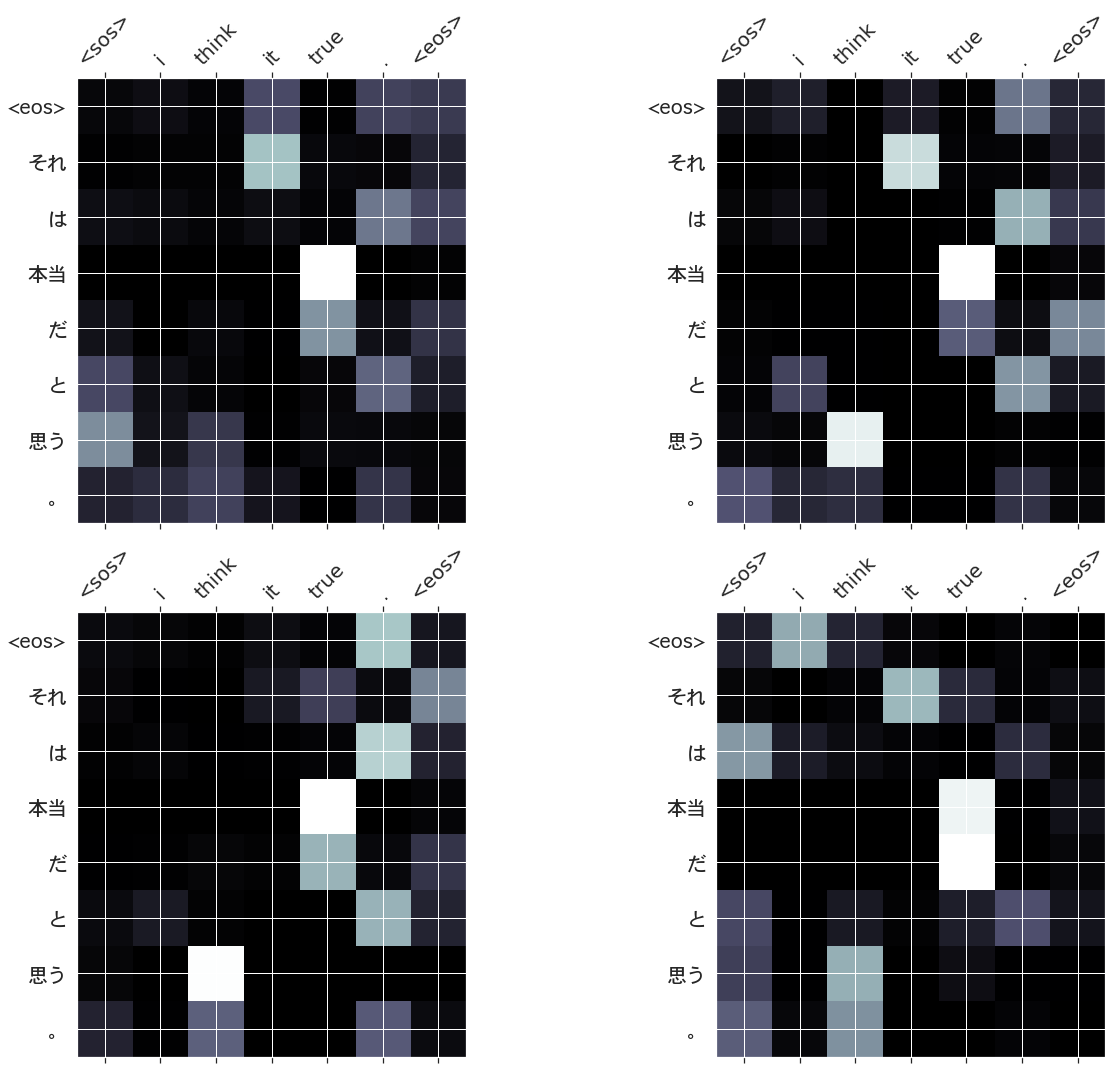

In [49]:
example_idx = random.randint(0, len(train_data) - 1)

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention)

src      : i 'll never forget talking with him there .
trg      : そこで 彼 と 話す た の を 決して 忘れる ない です う 。
predicted: <eos> そこで 彼 と 話す の を 決して 忘れる ます ん 。
     blue: 76.89%


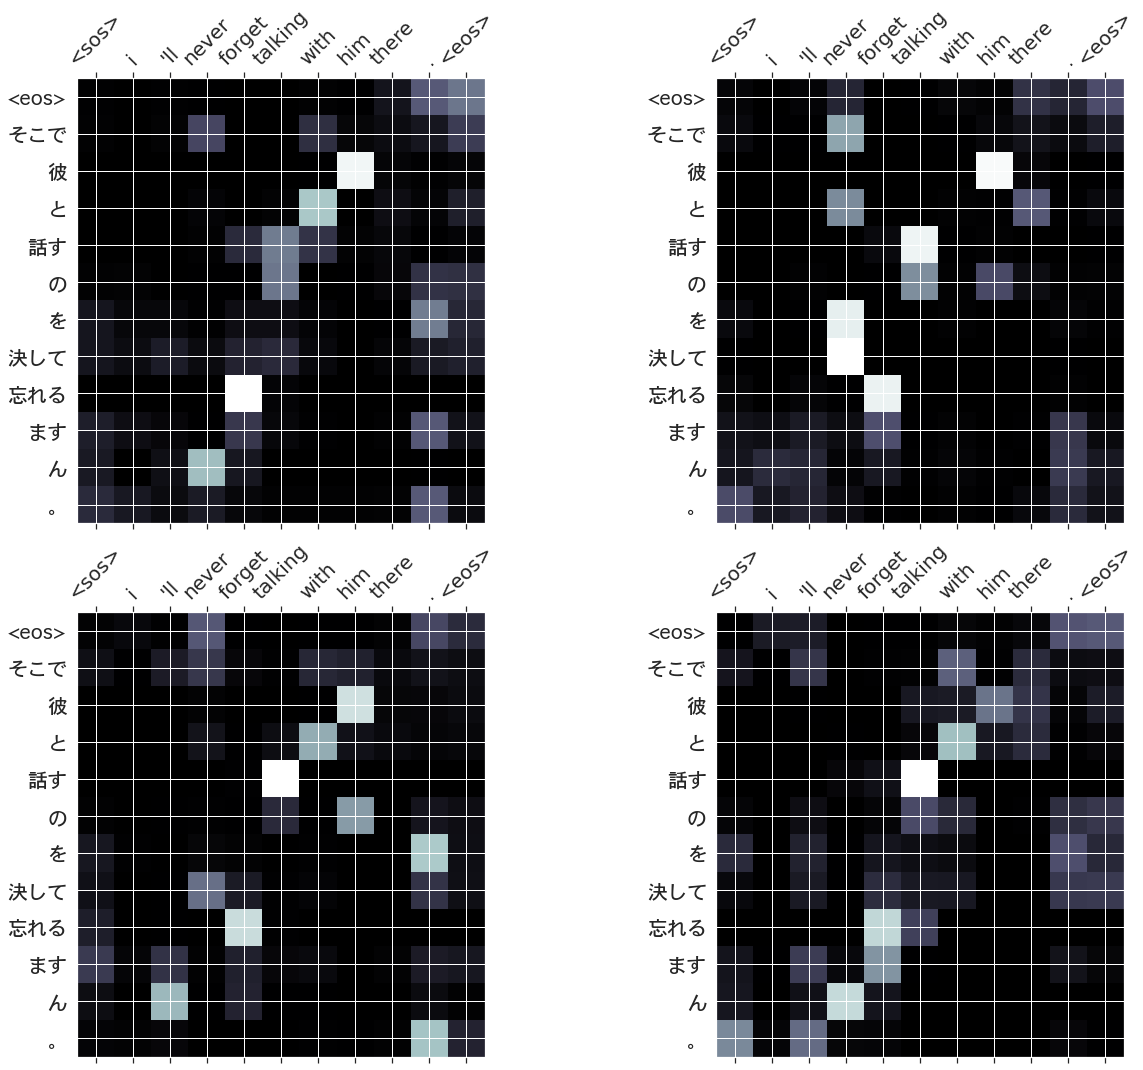

In [50]:
example_idx = random.randint(0, len(valid_data) - 1)

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention)

src      : my life changed , sparked by meeting mr matsukawa .
trg      : 松川 先生 と の 出会い を きっかけ に 、 私 の 人生 は 変わる た 。
predicted: <eos> 私 の 生活 を 変える て 、 <unk> 氏 は <unk> に なる た 。
     blue: 81.10%


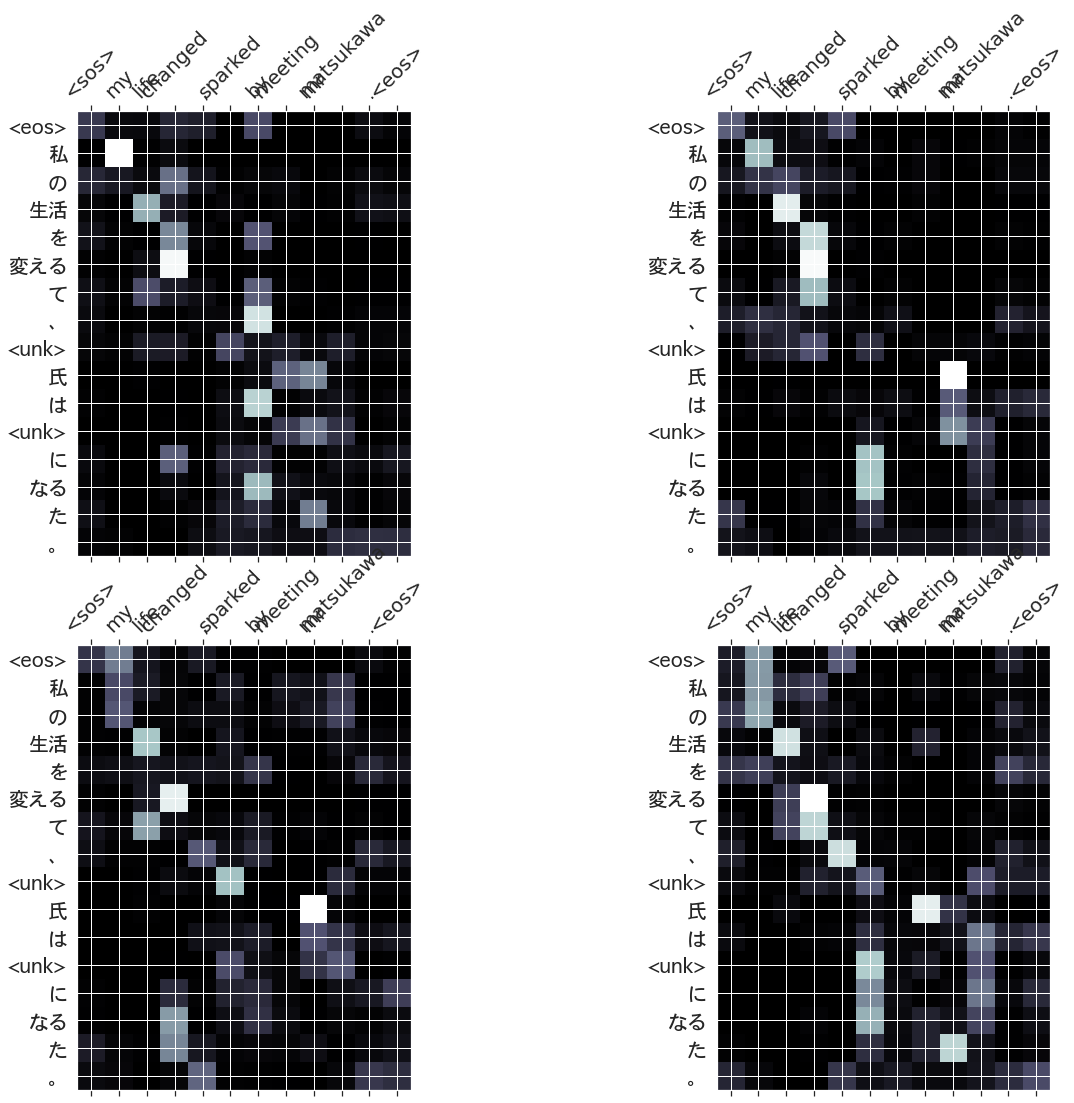

In [51]:
example_idx = random.randint(0, len(test_data) - 1)

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention)

src      : the girl looked embarrassed at his rude question .
trg      : 彼 の ぶす つける だ 質問 に 少女 は 当惑 する た 様子 だ た 。
predicted: <eos> その 少女 は 彼 の 失礼 だ 質問 に 当惑 する た 。
     blue: 85.66%


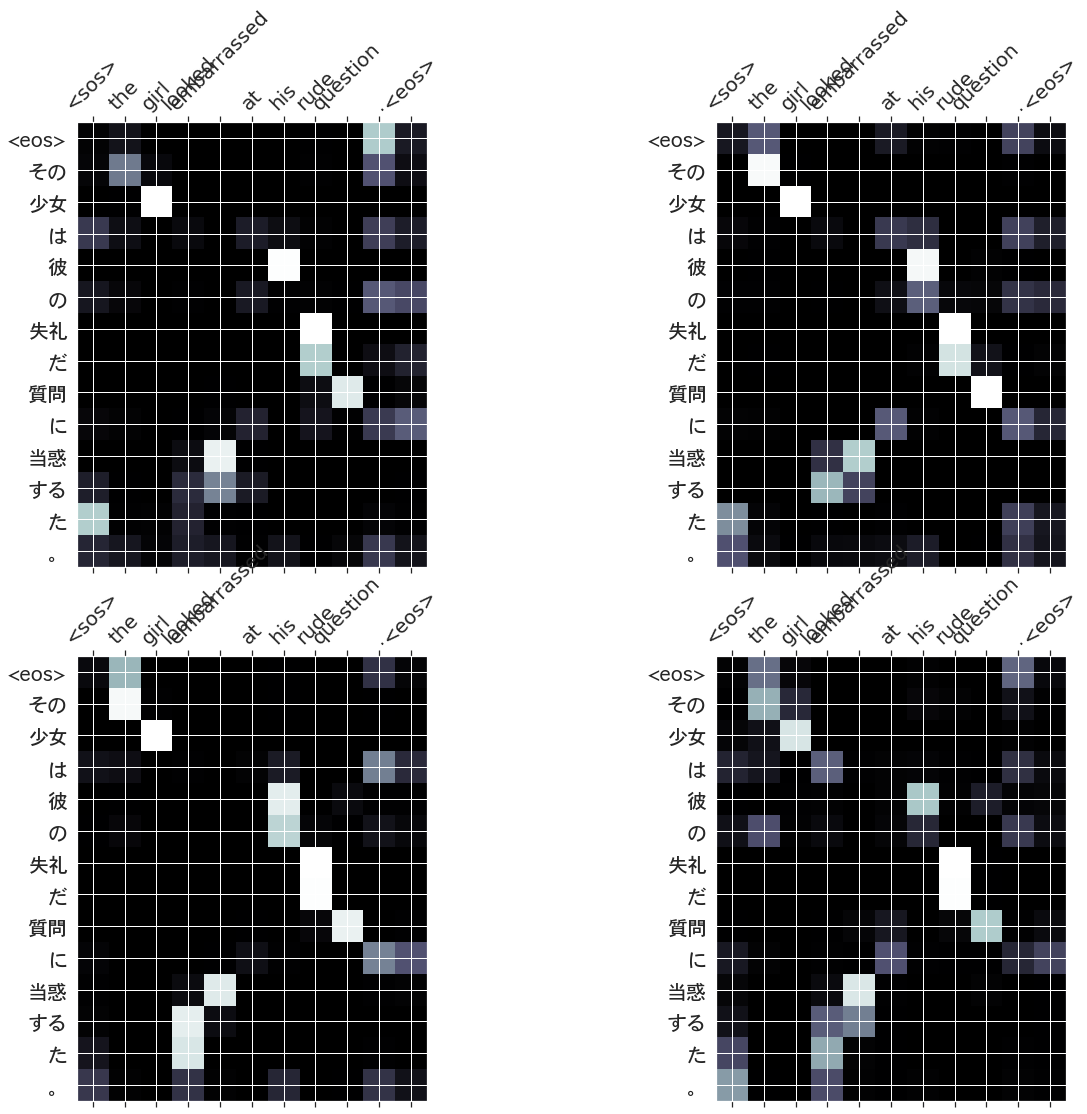

src      : i was very poor in those days .
trg      : その 頃 、 私 は 非常 に 貧乏 だ た 。
predicted: <eos> 私 は 当時 とても 貧しい た 。
     blue: 86.94%


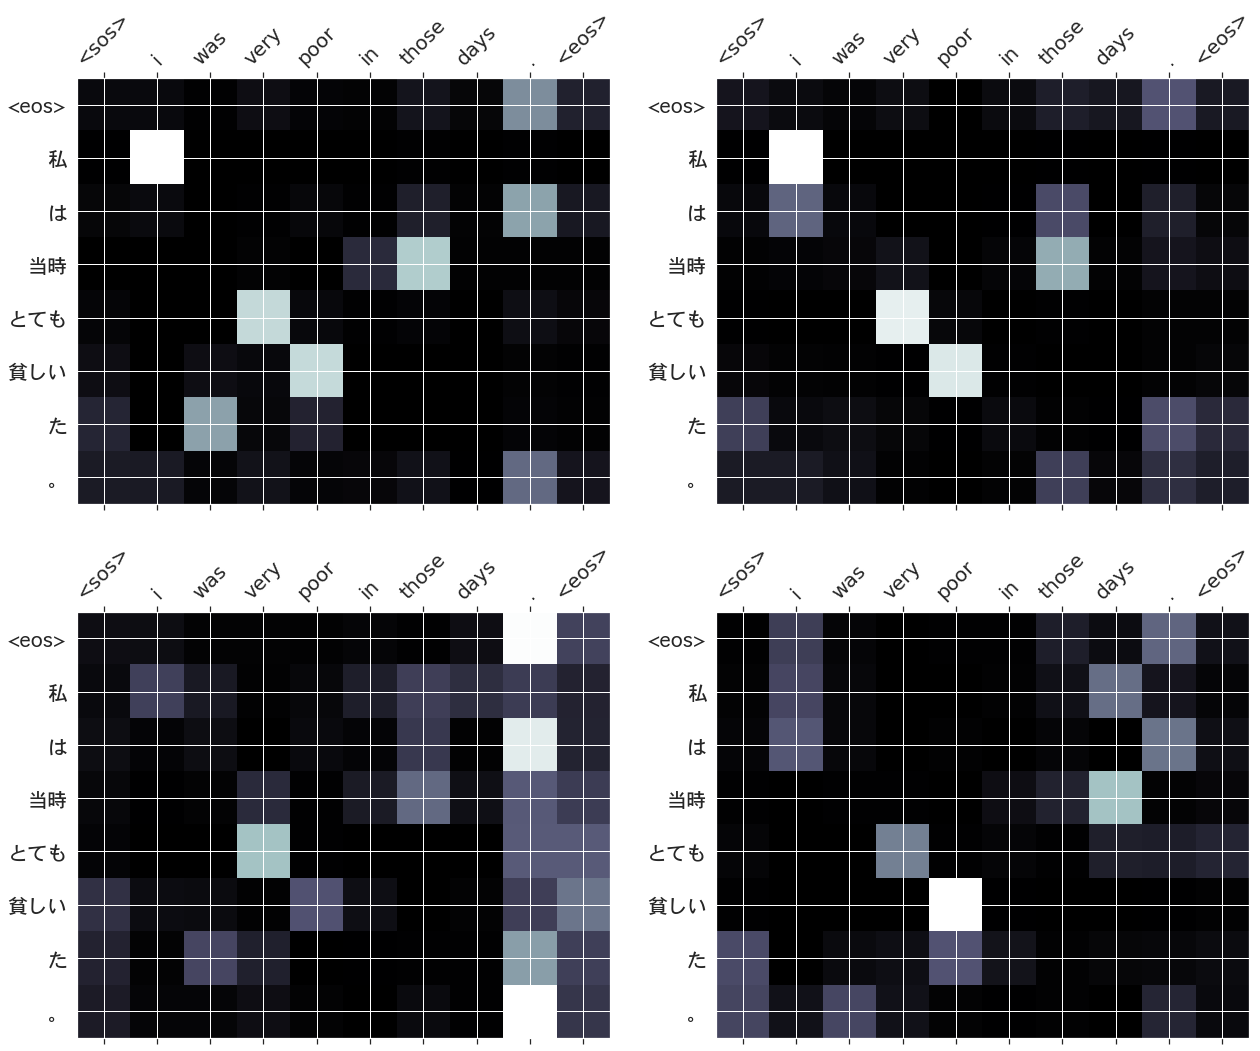

src      : let me get you something to drink .
trg      : あなた に 何 か 飲み物 を 持つ て くる て あげる う 。
predicted: <eos> 飲み物 を 何 か 飲む せる て 下さる 。
     blue: 86.33%


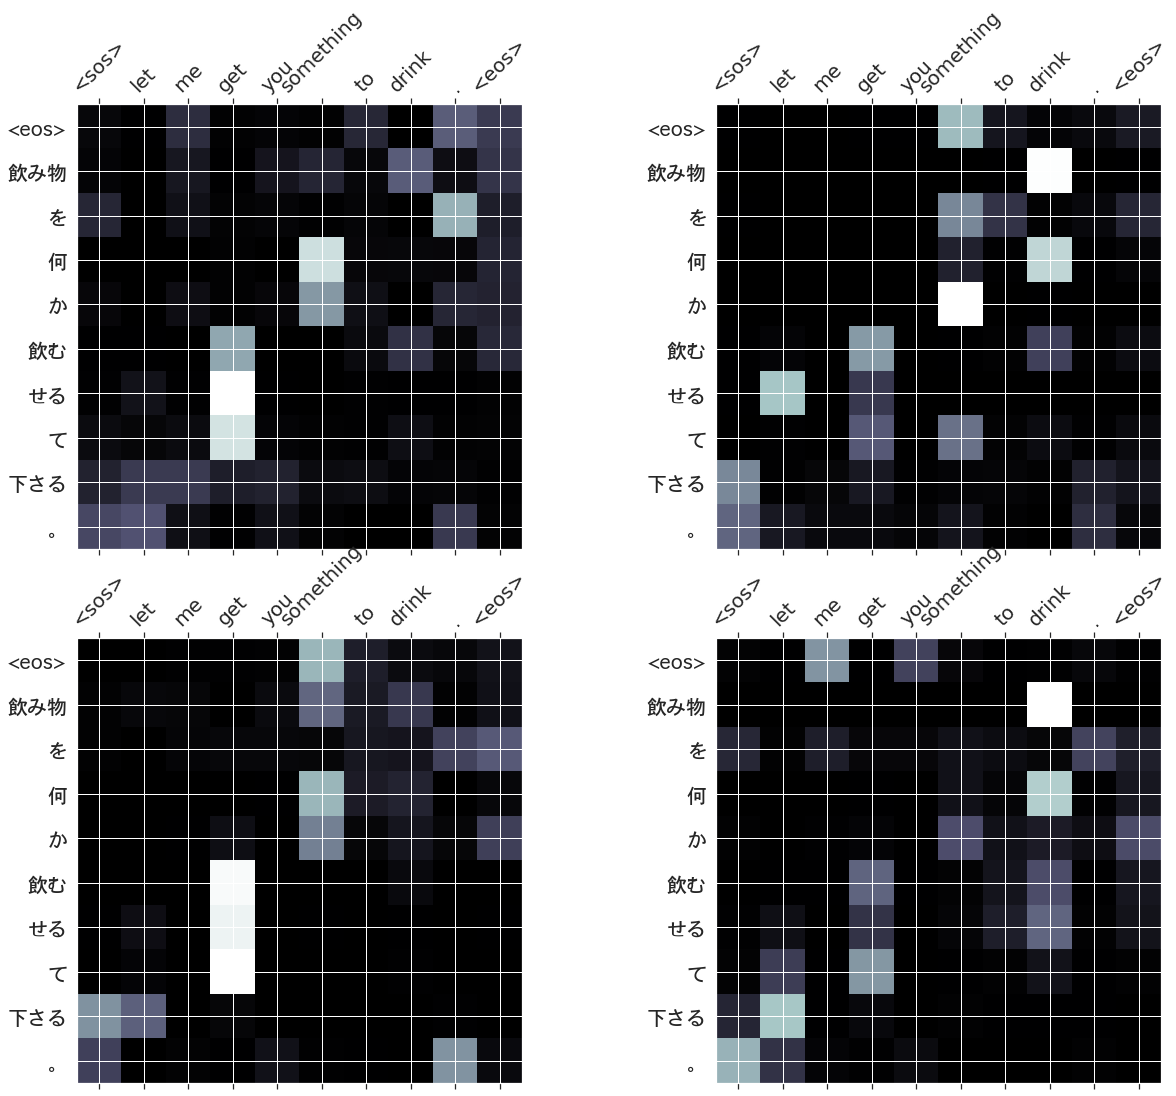

src      : he took an uncertain stance .
trg      : 彼 は あいまい だ 態度 を とる た 。
predicted: <eos> 彼 は 決して 確実 だ こと を 知る ない た 。
     blue: 85.94%


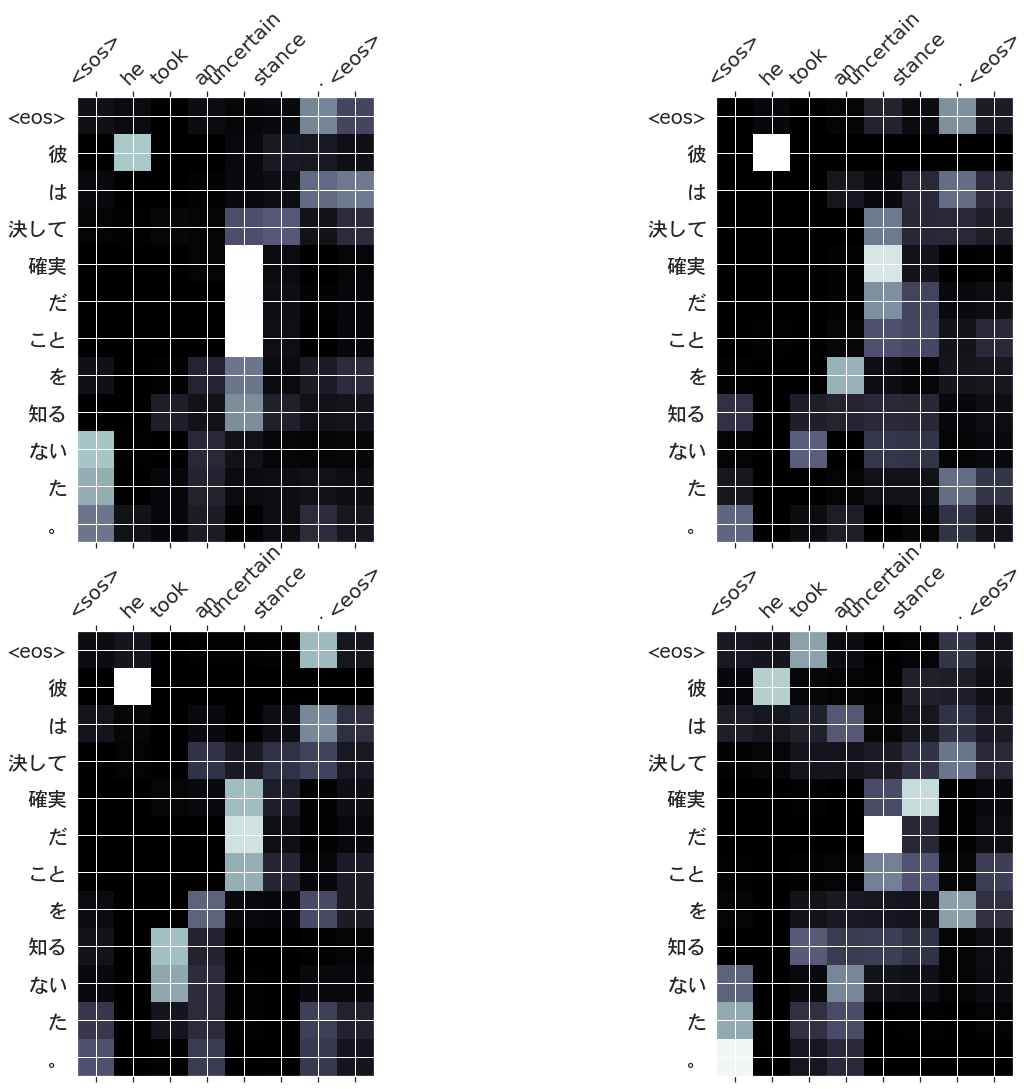

src      : do n't be angry .
trg      : 怒る な よ 。
predicted: <eos> 怒る な 。
     blue: 90.36%


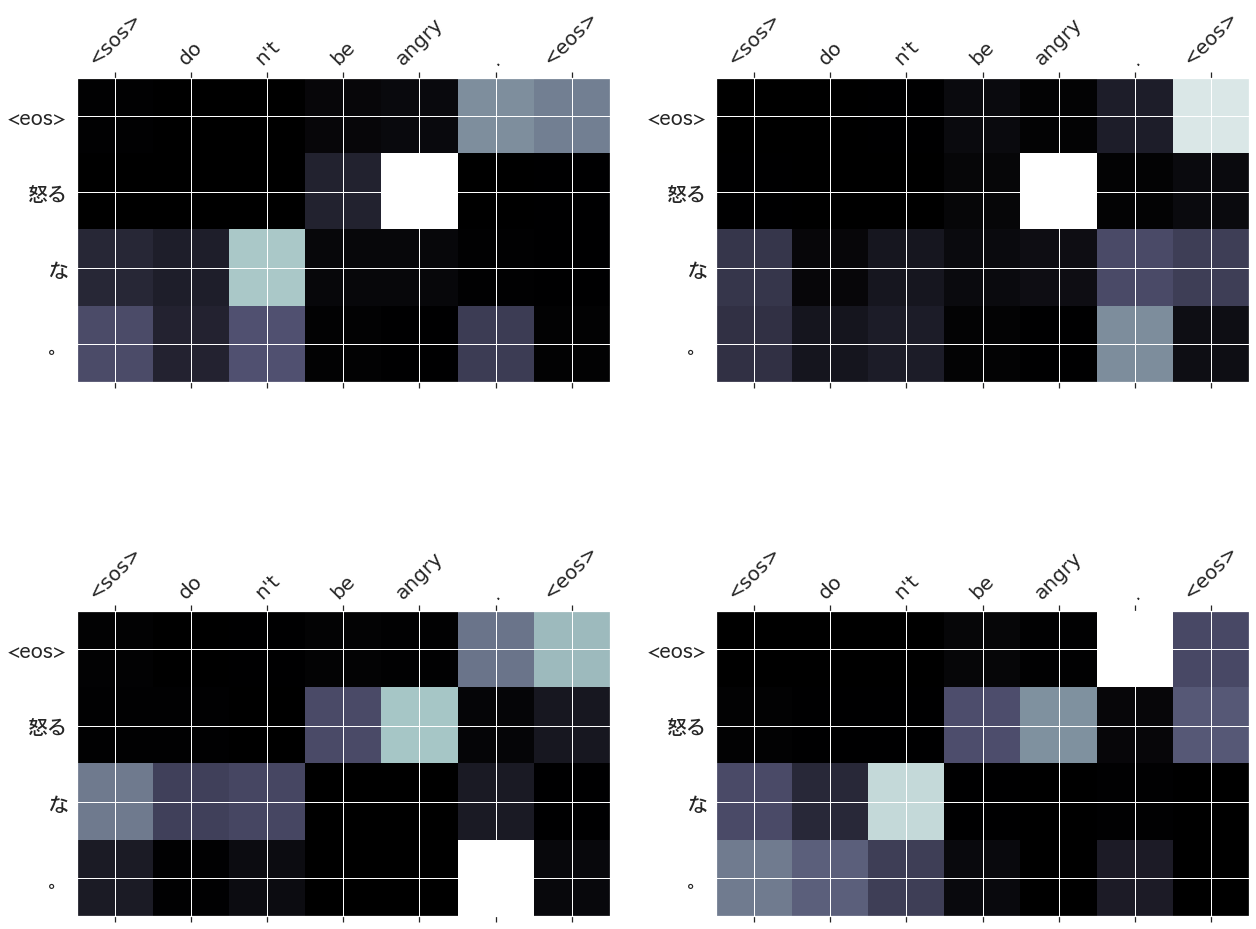

src      : i 'm healthy .
trg      : 私 は 体 は 健康 です 。
predicted: <eos> 私 は 健康 です 。
     blue: 88.01%


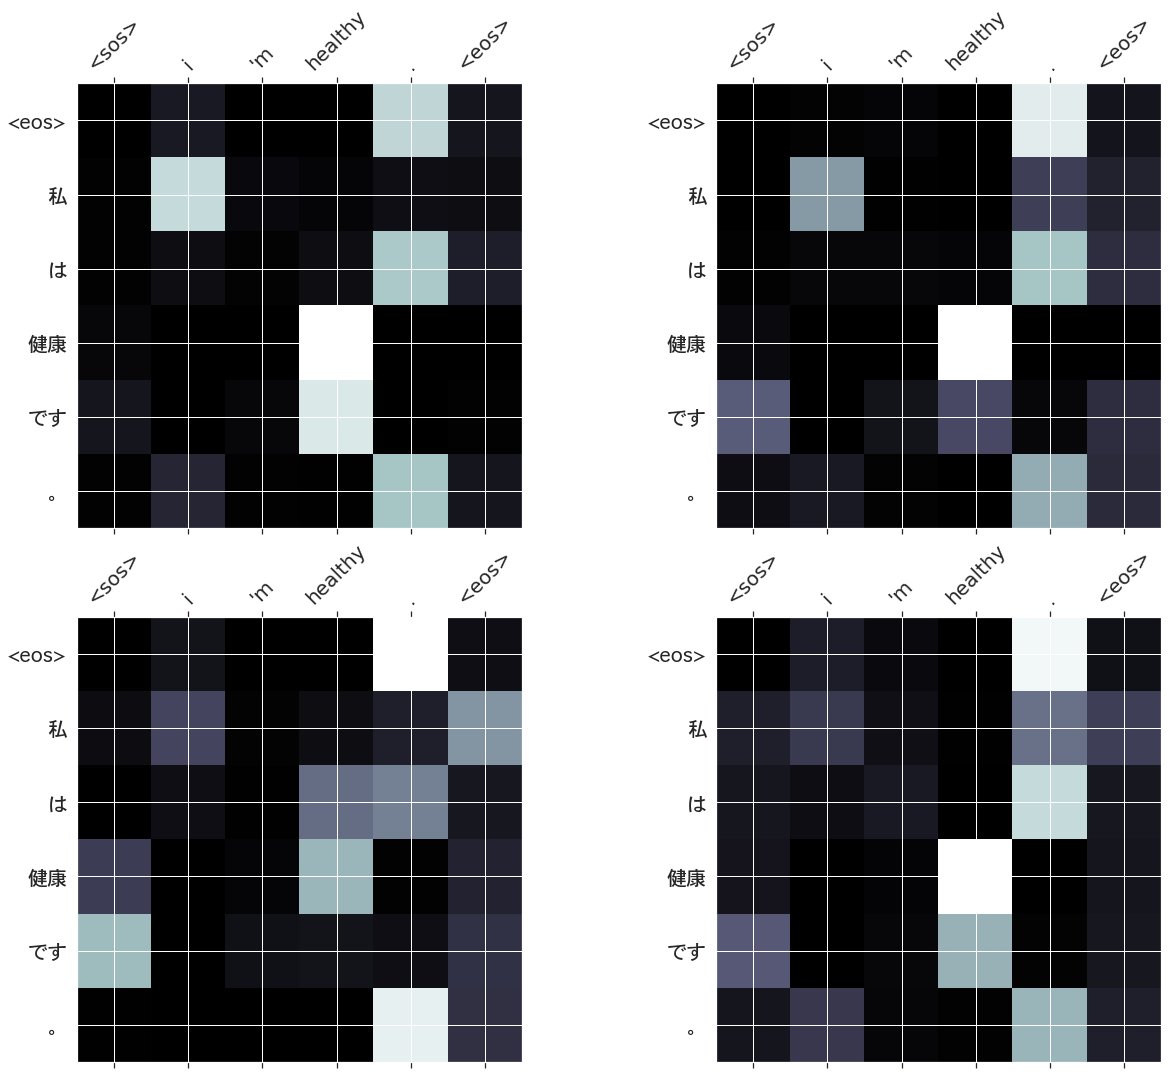

src      : he exhausted all his energy .
trg      : 彼 は 体力 を すべて 使い果たす た 。
predicted: <eos> 彼 は 全 精力 を 使い果たす た 。
     blue: 88.91%


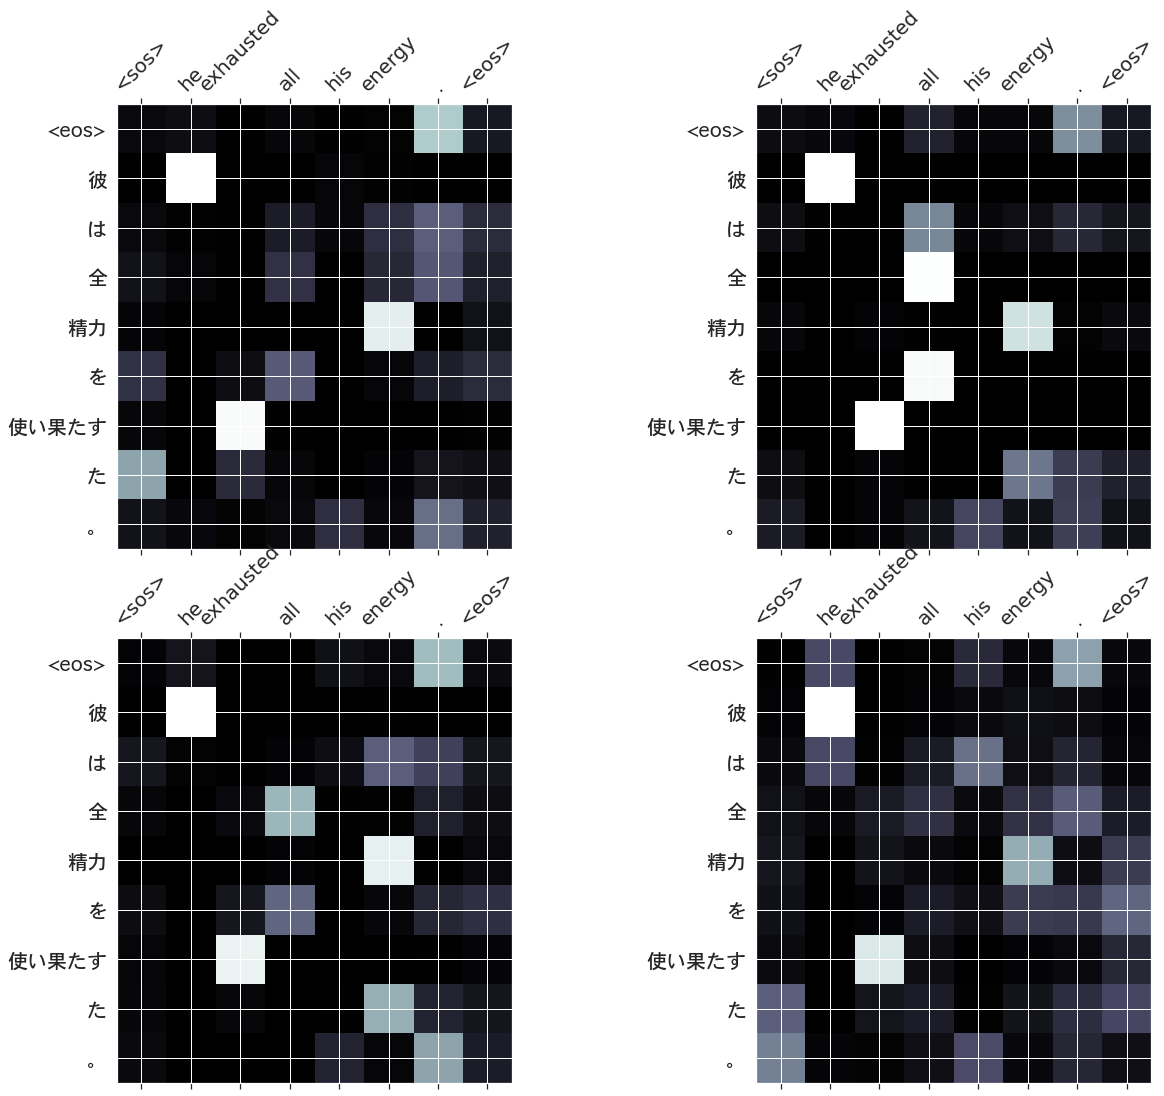

src      : let me get you something to drink .
trg      : あなた に 何 か 飲み物 を 持つ て くる て あげる う 。
predicted: <eos> 飲み物 を 何 か 飲む せる て 下さる 。
     blue: 86.33%


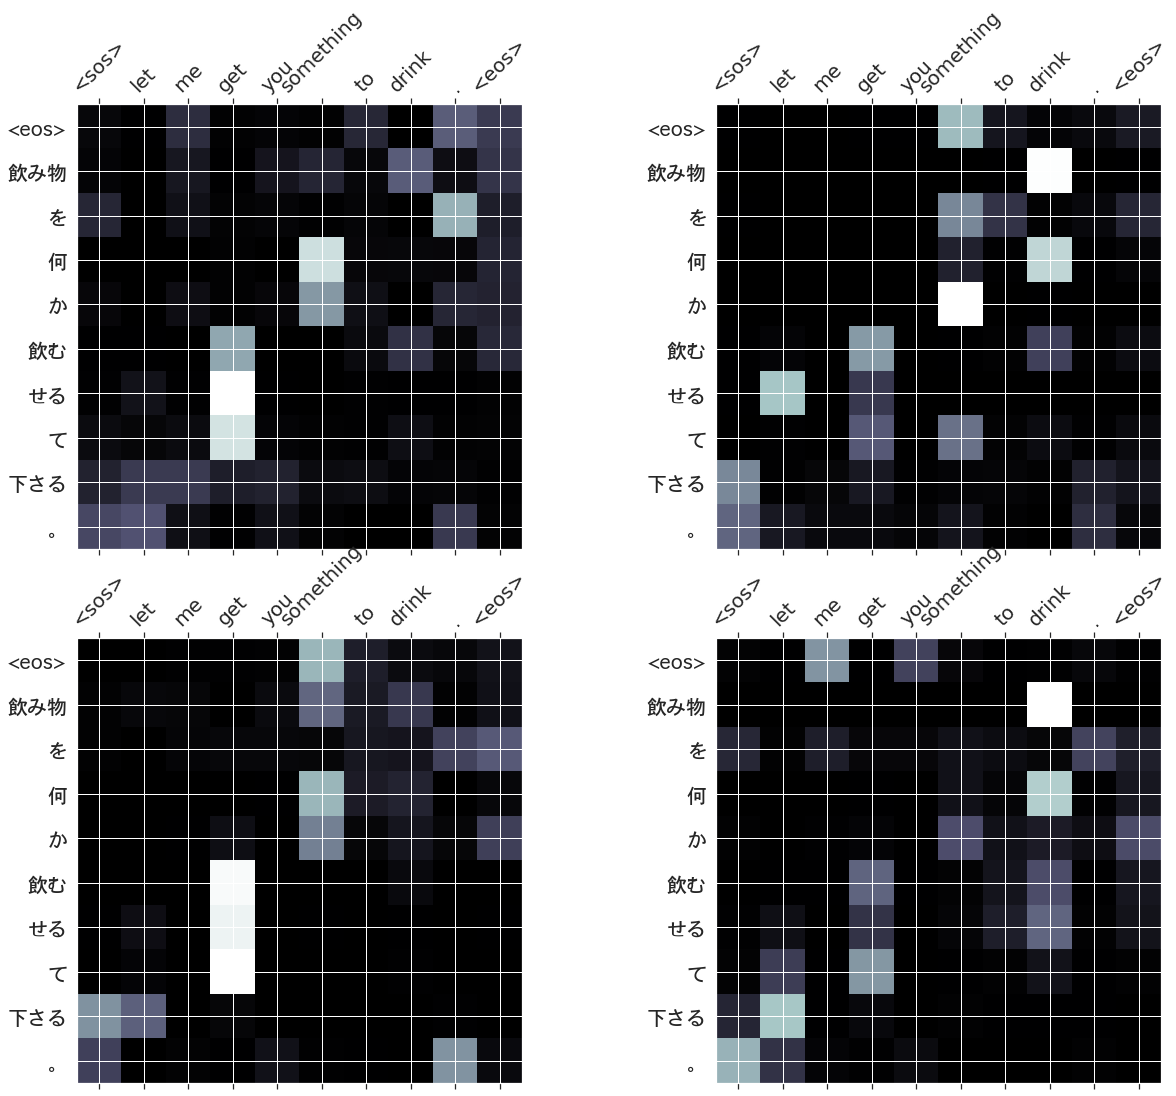

src      : he differs from his brother .
trg      : 彼 は 兄さん と は 異なる 。
predicted: <eos> 彼 は 兄 と は 違う 。
     blue: 91.93%


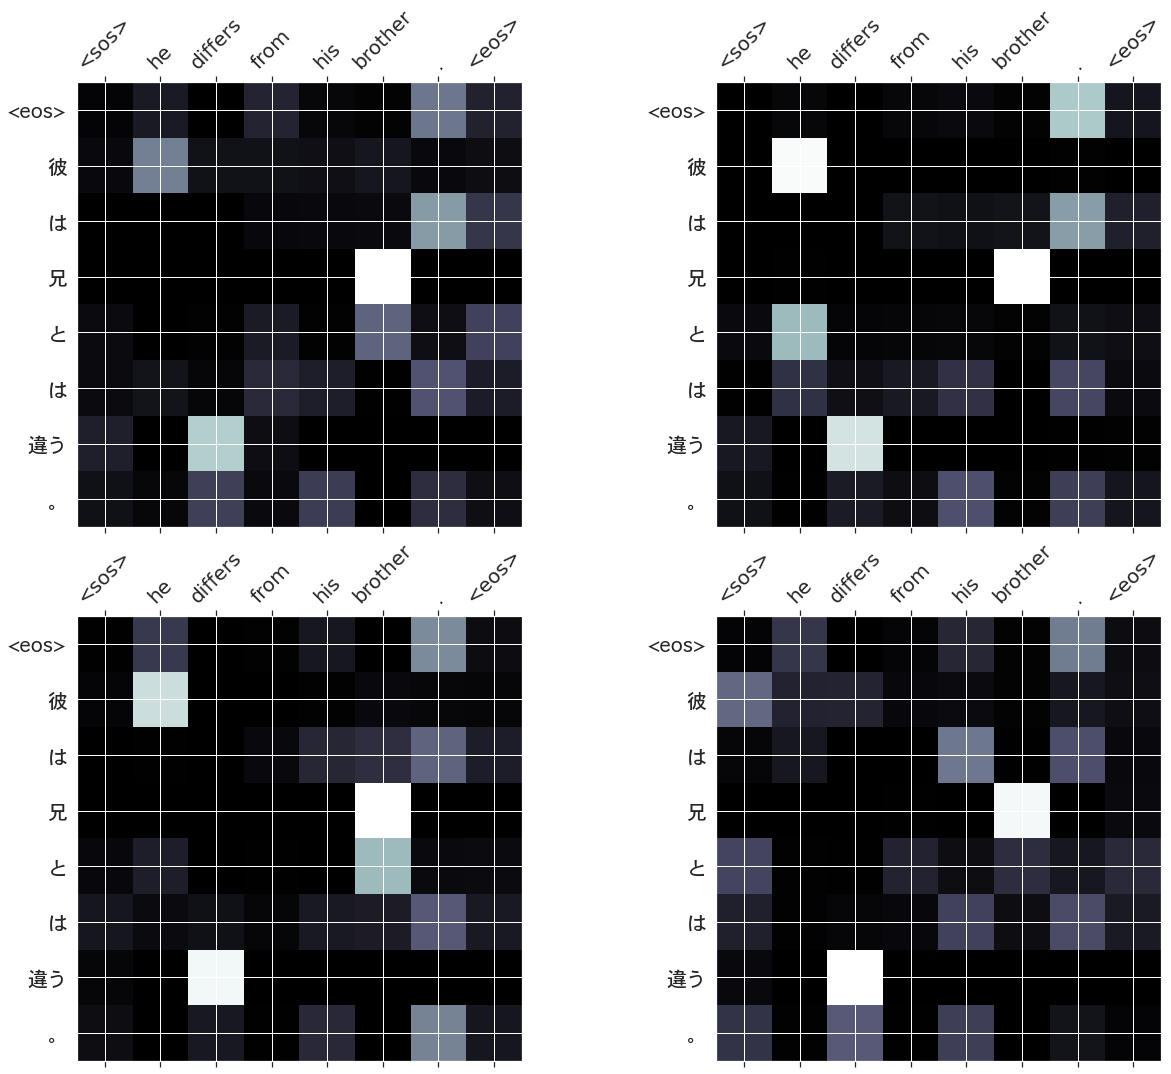

src      : she gave me a strange look .
trg      : 彼女 は 私 を 変 だ 目 で 見る た 。
predicted: <eos> 彼女 は 私 に 変 だ 顔 を くれる た 。
     blue: 89.32%


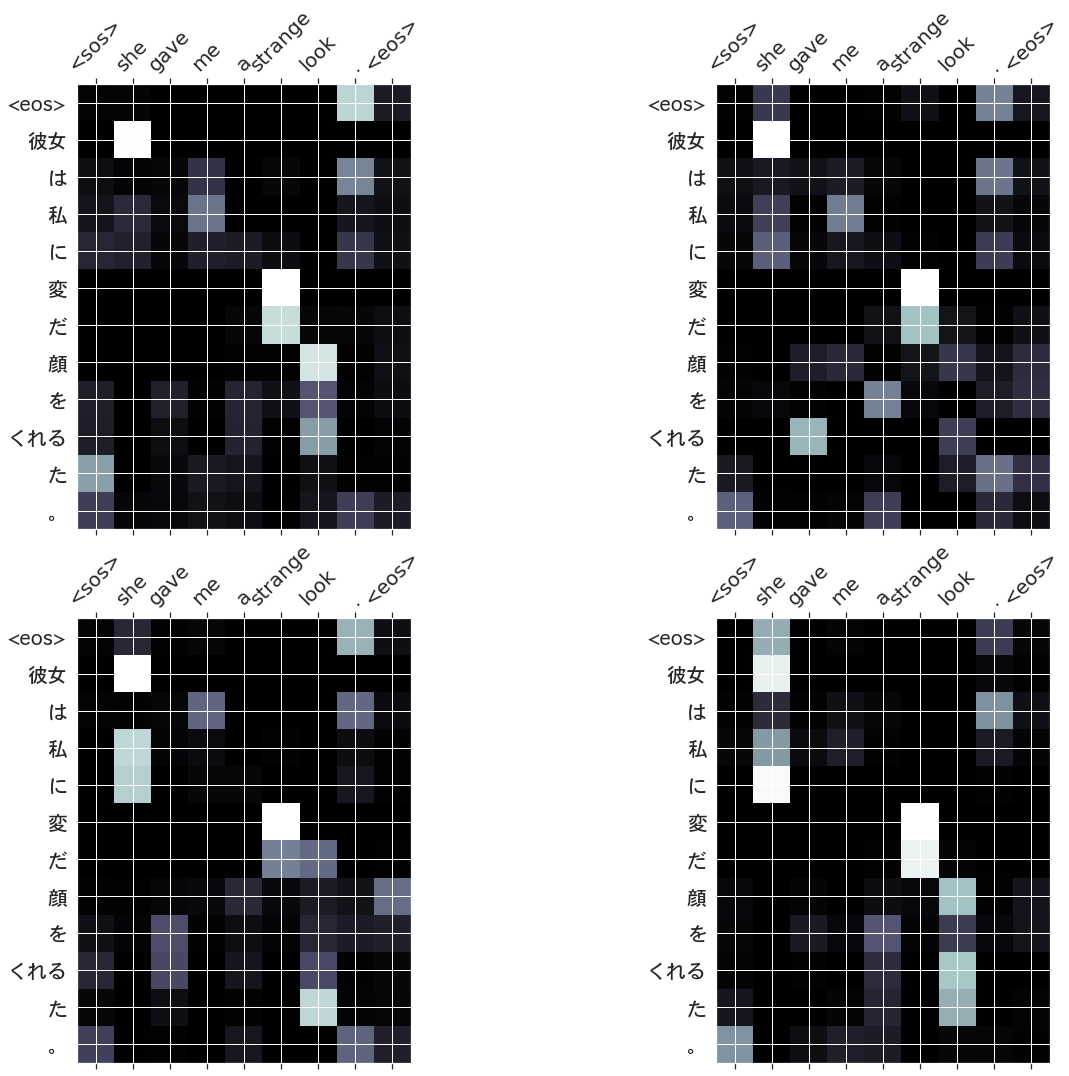

src      : his behavior is worthy of respect .
trg      : 彼 の 振る舞い は 尊敬 に 値する 。
predicted: <eos> 彼 の 振る舞い は 尊敬 に 値する 。
     blue: 88.91%


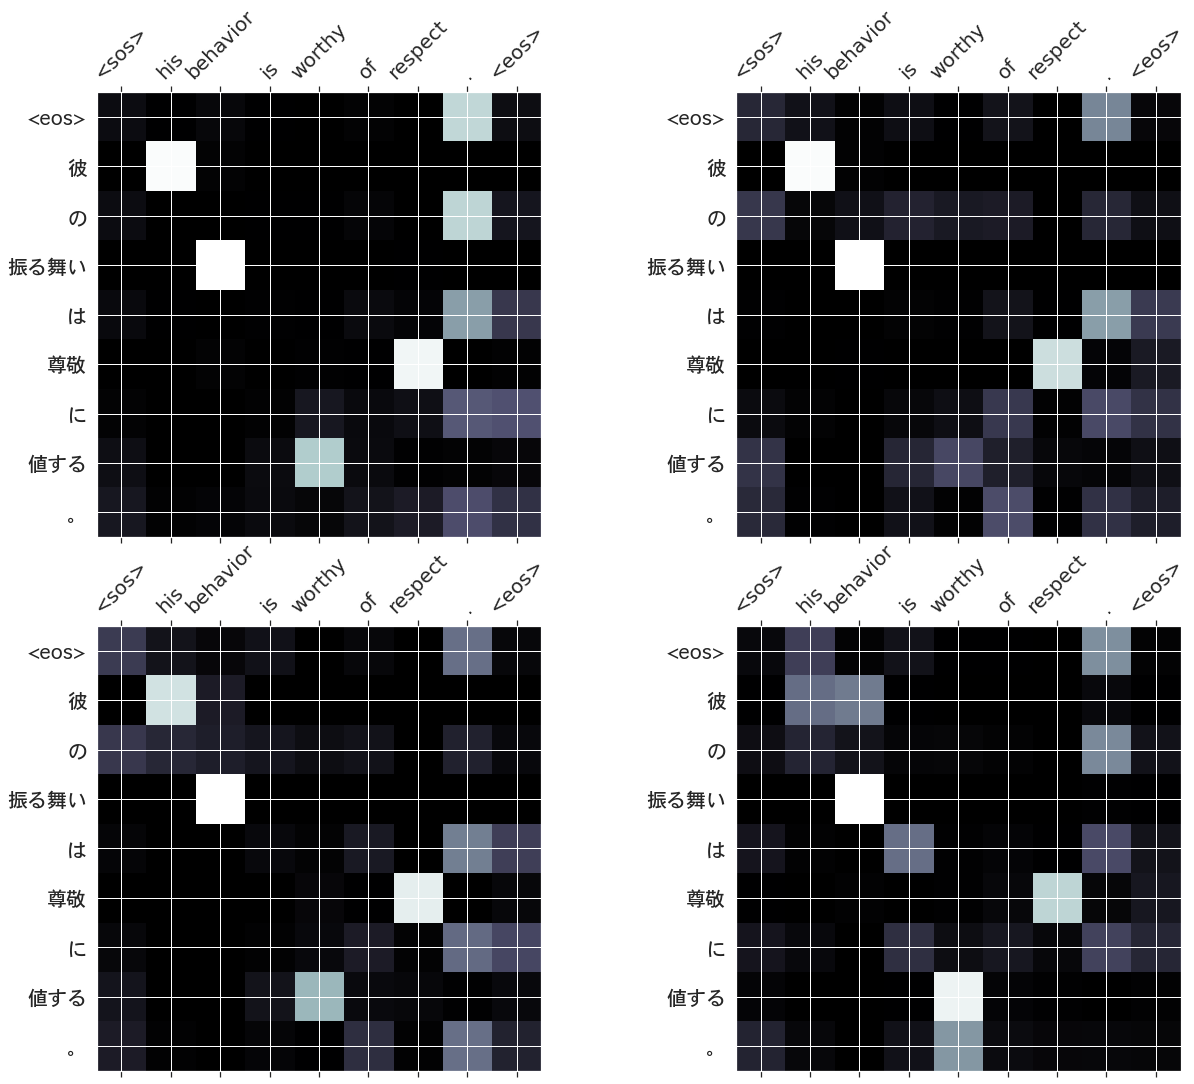

src      : i met him early this morning .
trg      : 私 は 今朝 早い 彼 に 会う た 。
predicted: <eos> けさ は 早い 彼 に 会う た 。
     blue: 88.91%


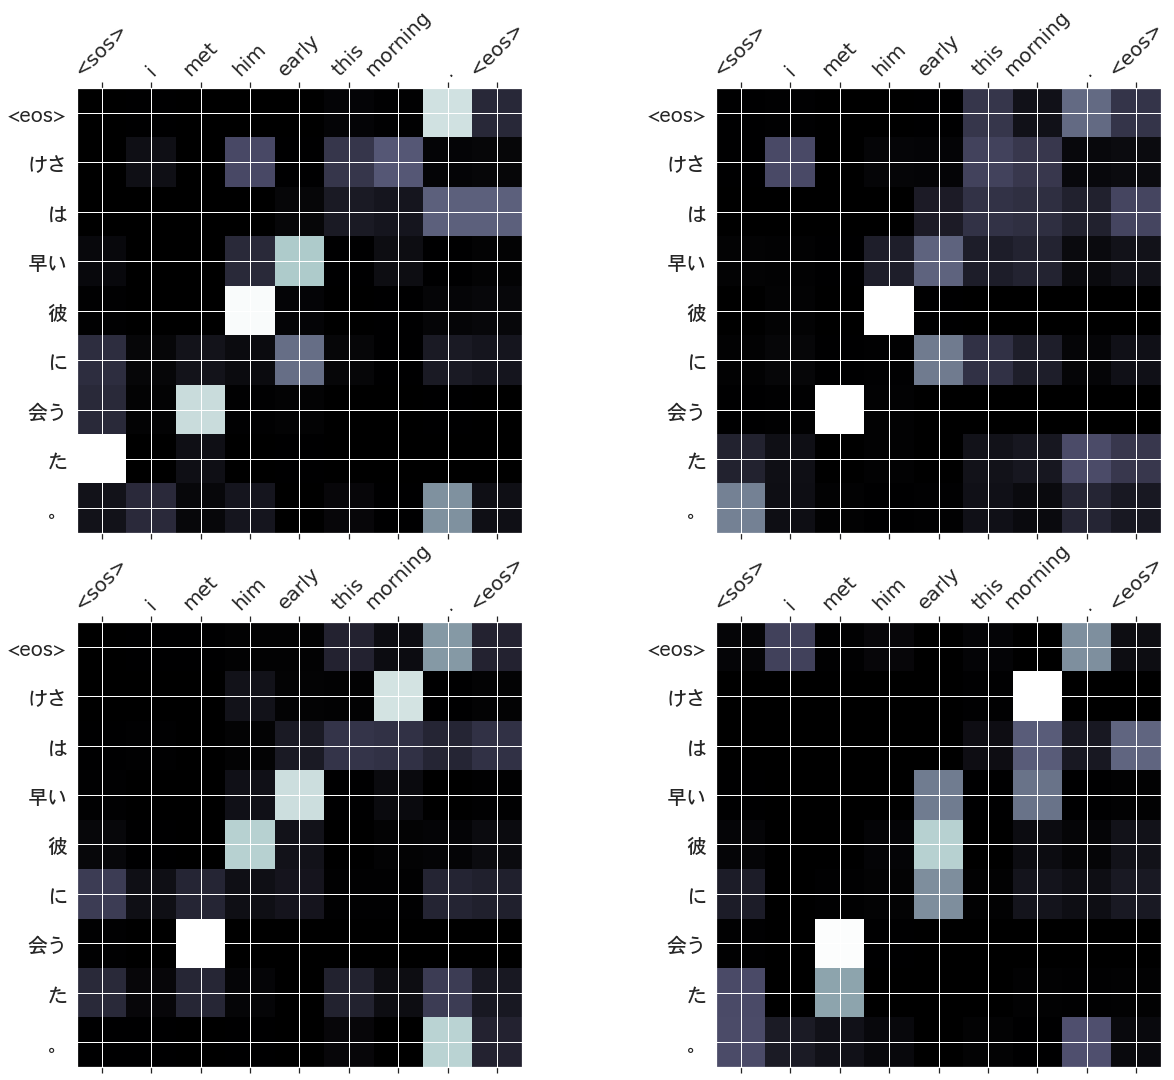

src      : he sensed that threat early in his career .
trg      : 彼 は 職 に つく た 頃 、 その 脅威 を 感じる た 。
predicted: <eos> 彼 は 仕事 の こと を 脅迫 に 気づく た 。
     blue: 89.32%


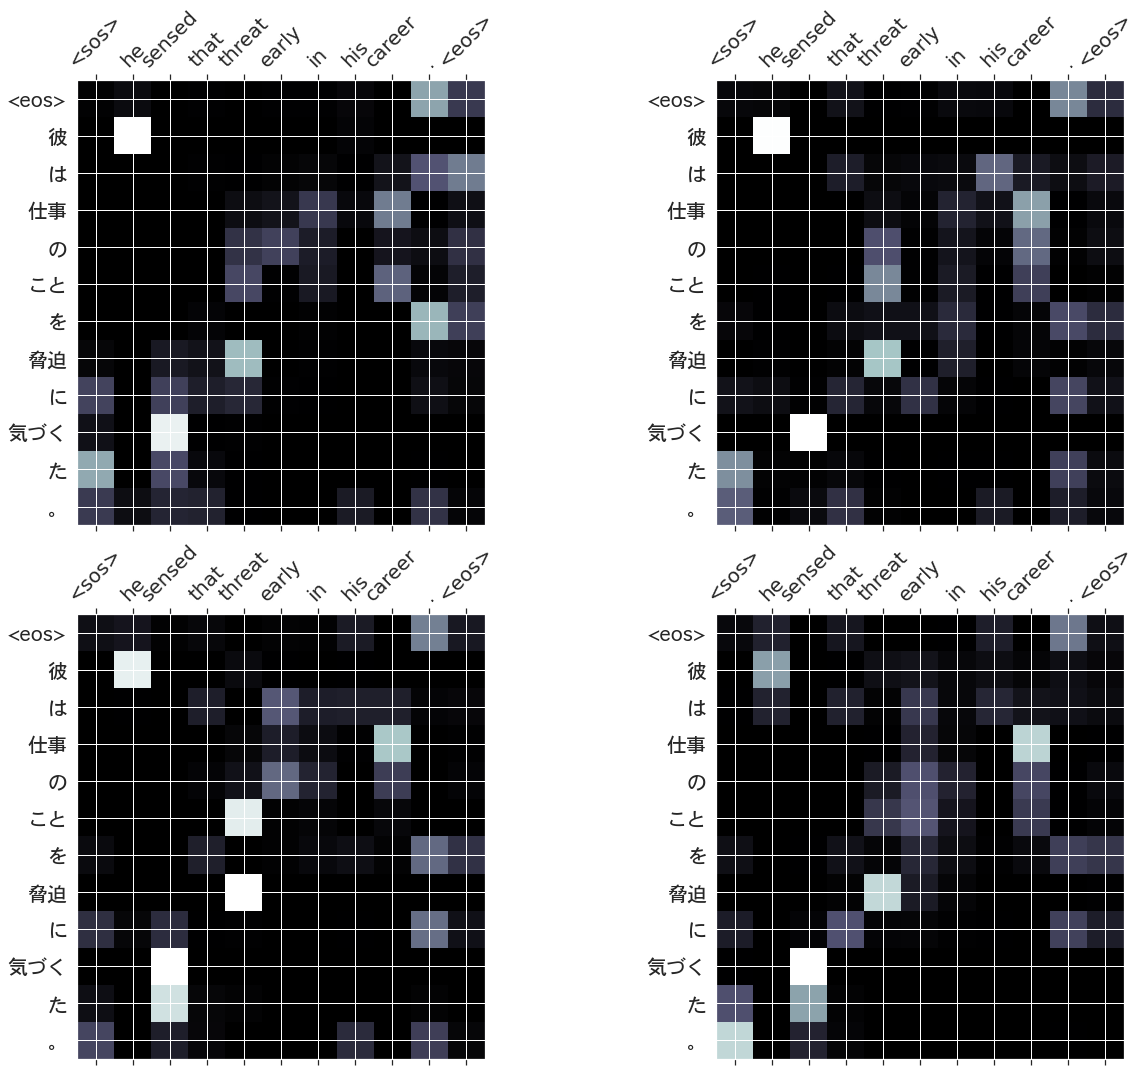

src      : my life changed , sparked by meeting mr matsukawa .
trg      : 松川 先生 と の 出会い を きっかけ に 、 私 の 人生 は 変わる た 。
predicted: <eos> 私 の 生活 を 変える て 、 <unk> 氏 は <unk> に なる た 。
     blue: 85.46%


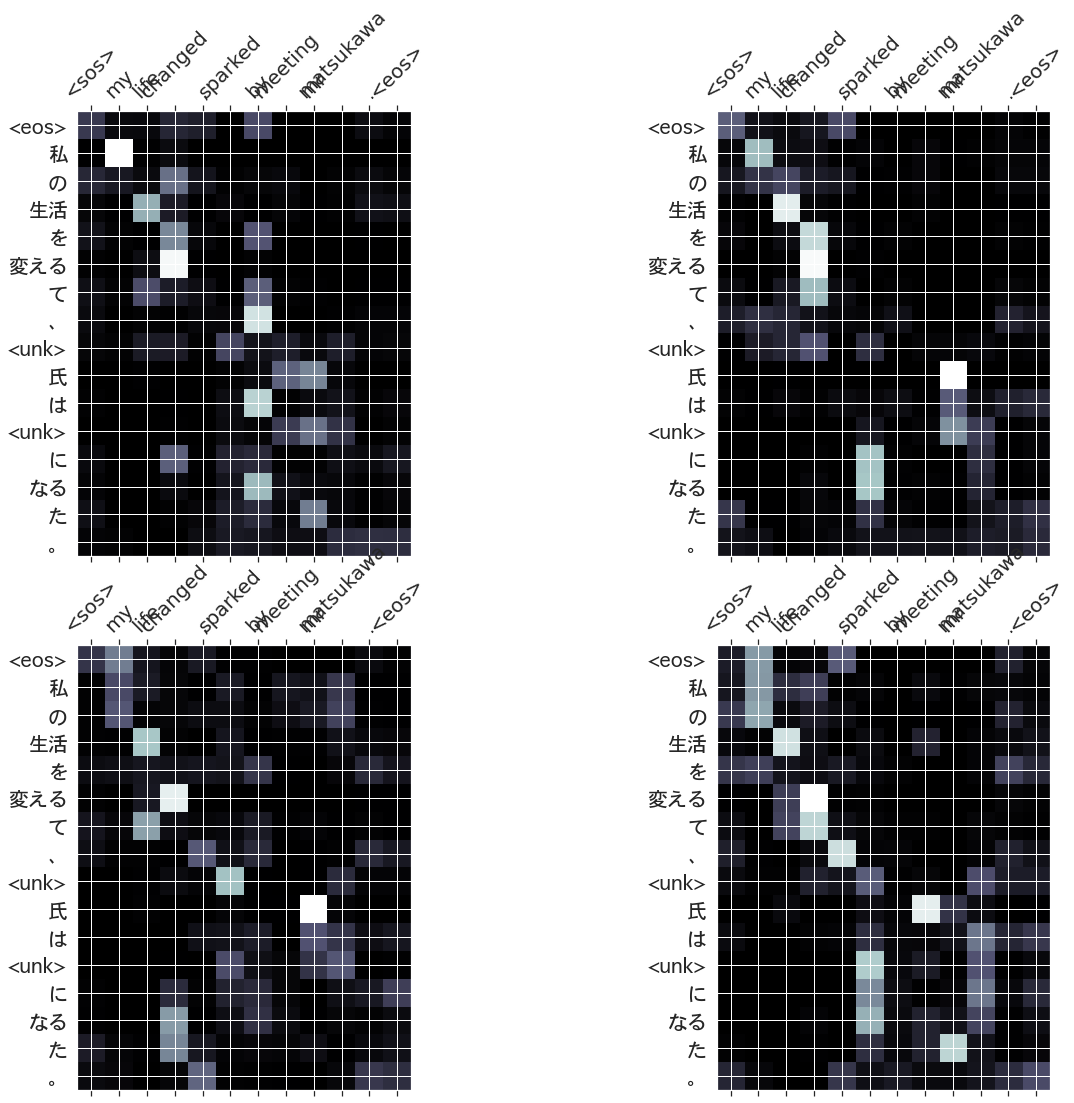

src      : it is probable that she will come .
trg      : たぶん 彼女 は 来る だ う 。
predicted: <eos> おそらく 彼女 は 来る だ う 。
     blue: 86.94%


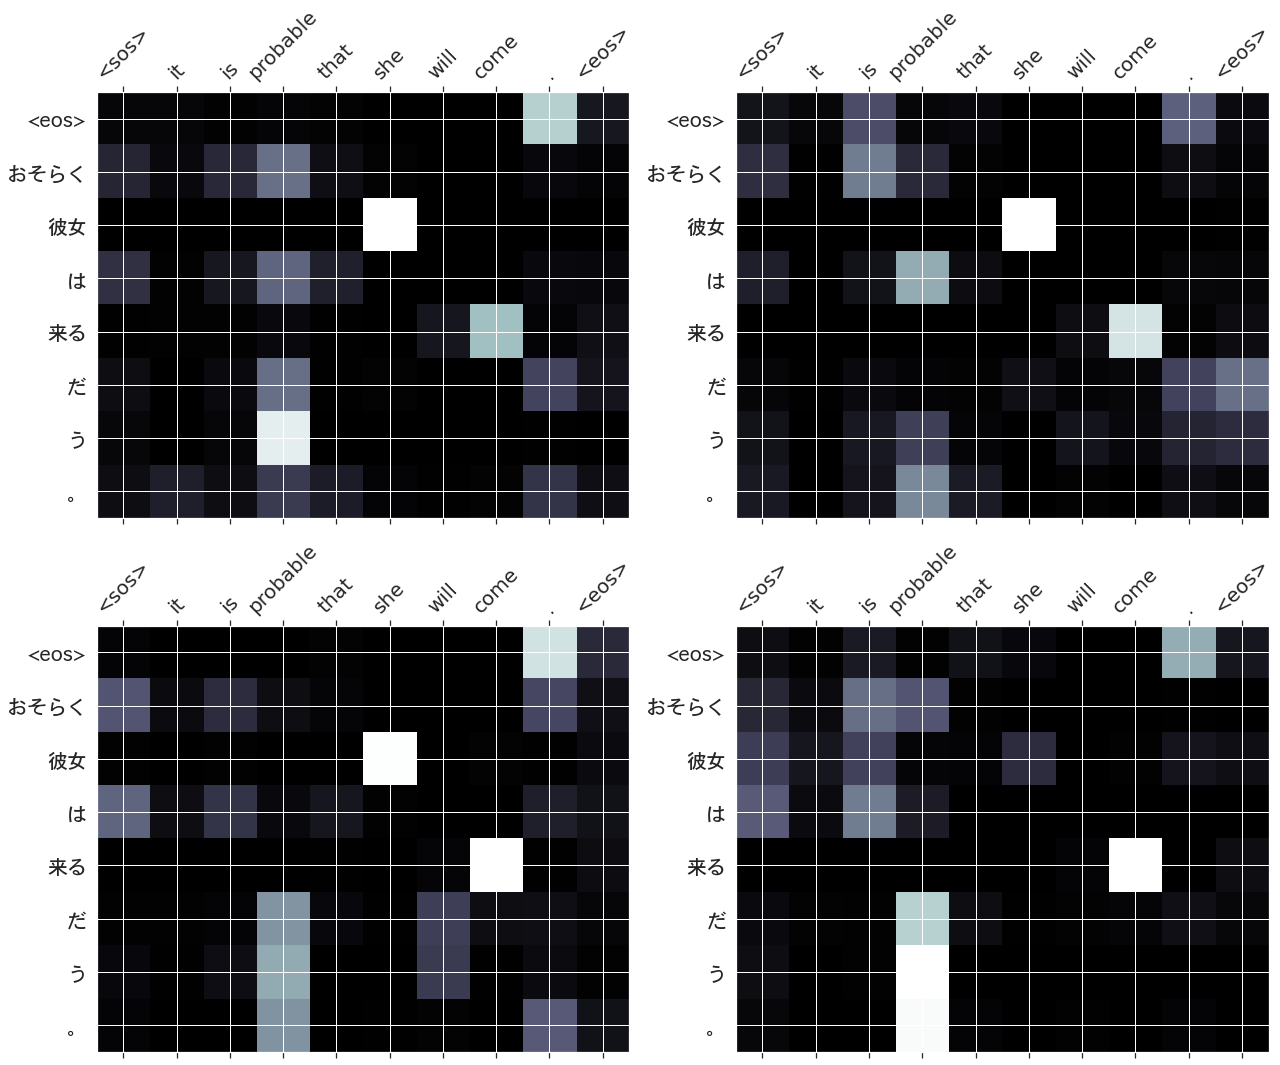

src      : the man walking over there is our teacher .
trg      : 向こう を 歩く て いる 男 の 人 は 私 達 の 先生 です 。
predicted: <eos> あそこ を 歩く て いる 人 は 私 たち の 先生 です 。
     blue: 85.66%


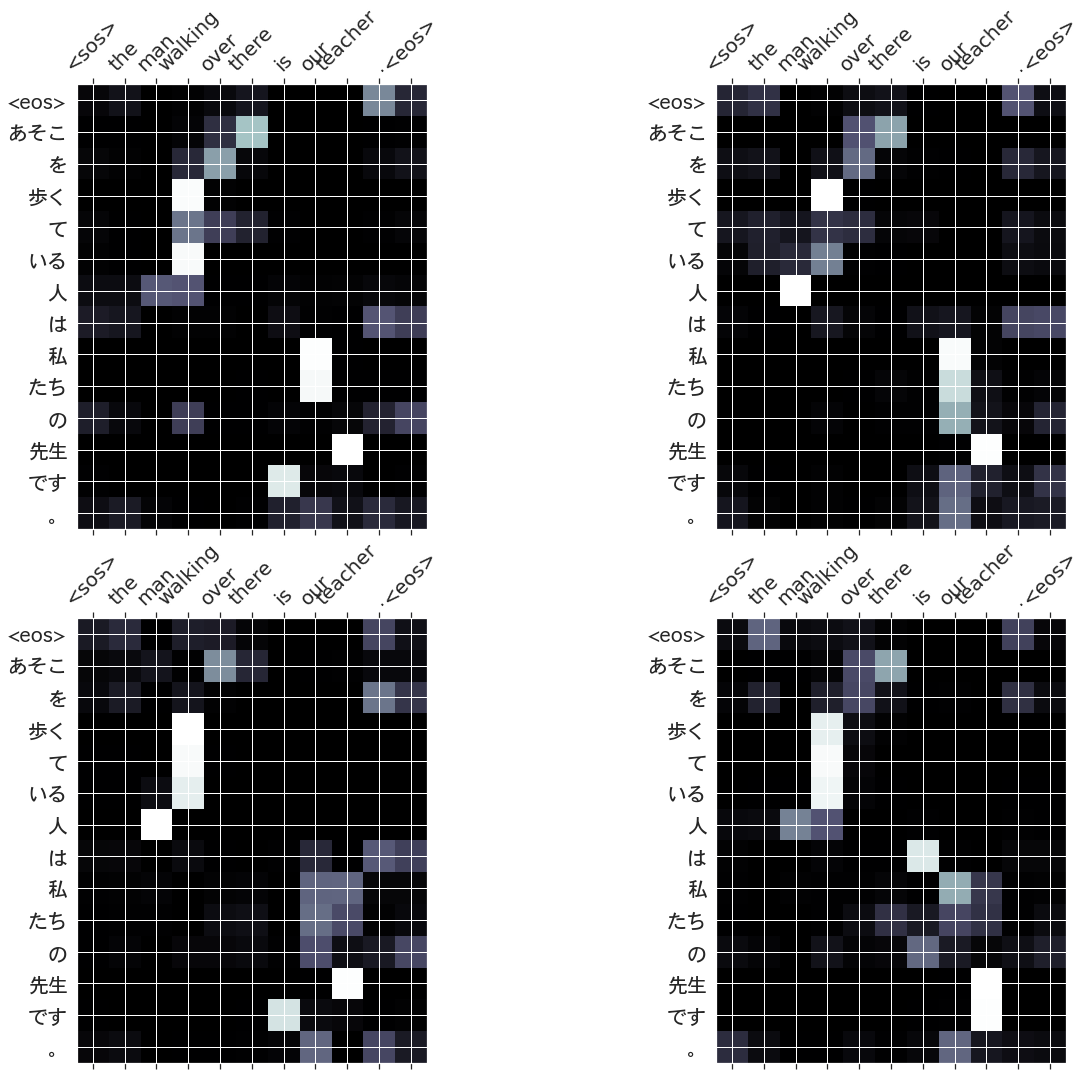

src      : he is one of the greatest scientists in japan .
trg      : 彼 は 日本 で 最も 偉大 だ 学者 の 一 人 です 。
predicted: <eos> 彼 は 日本 で もっとも 偉大 だ 科学 者 の 一 人 です 。
     blue: 89.54%


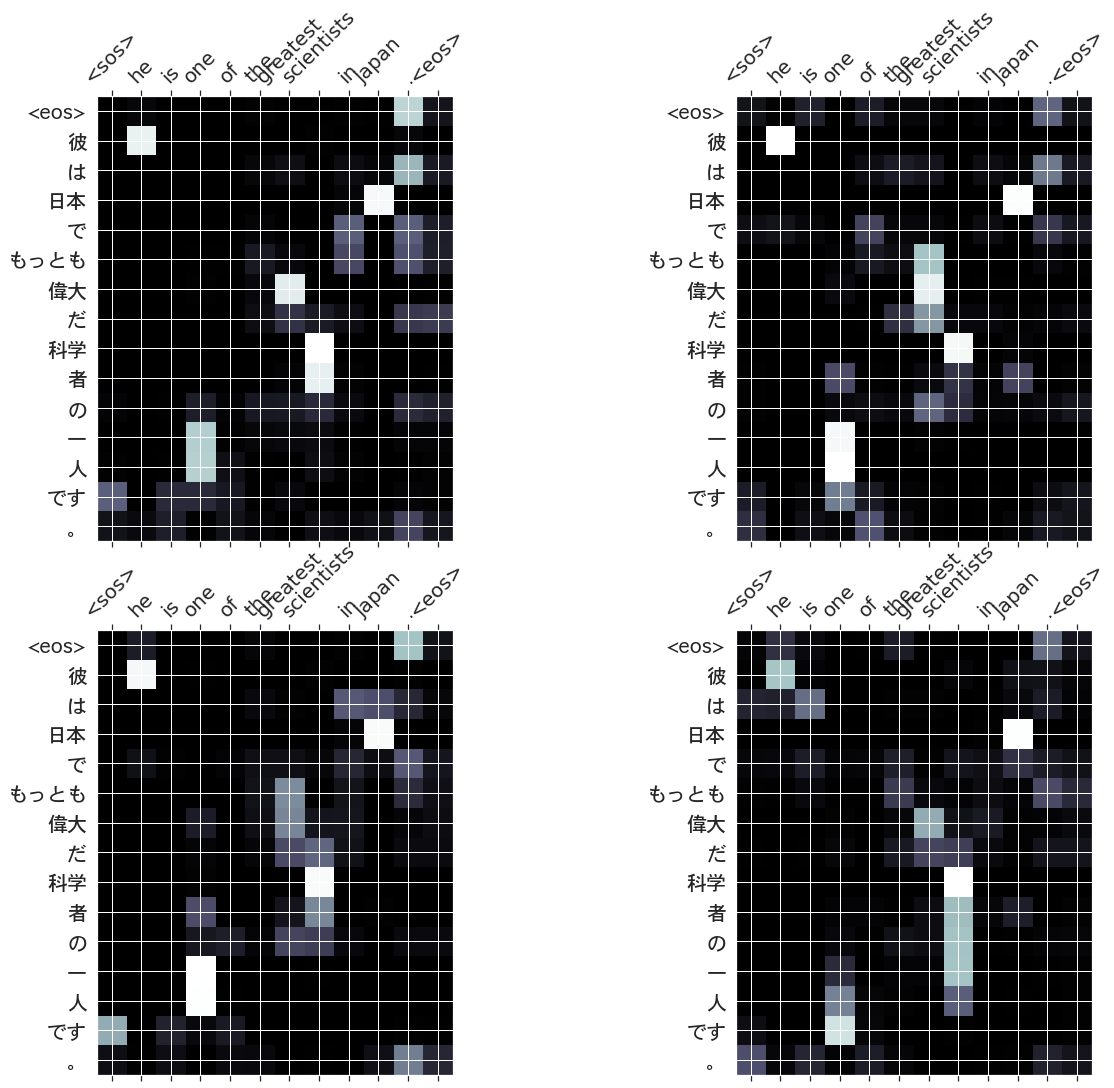

src      : michael caught her by the hand .
trg      : マイケル は 彼女 の 手 を 捕まえる た 。
predicted: <eos> マイケル は 彼女 の 手 を つかまえる た 。
     blue: 90.36%


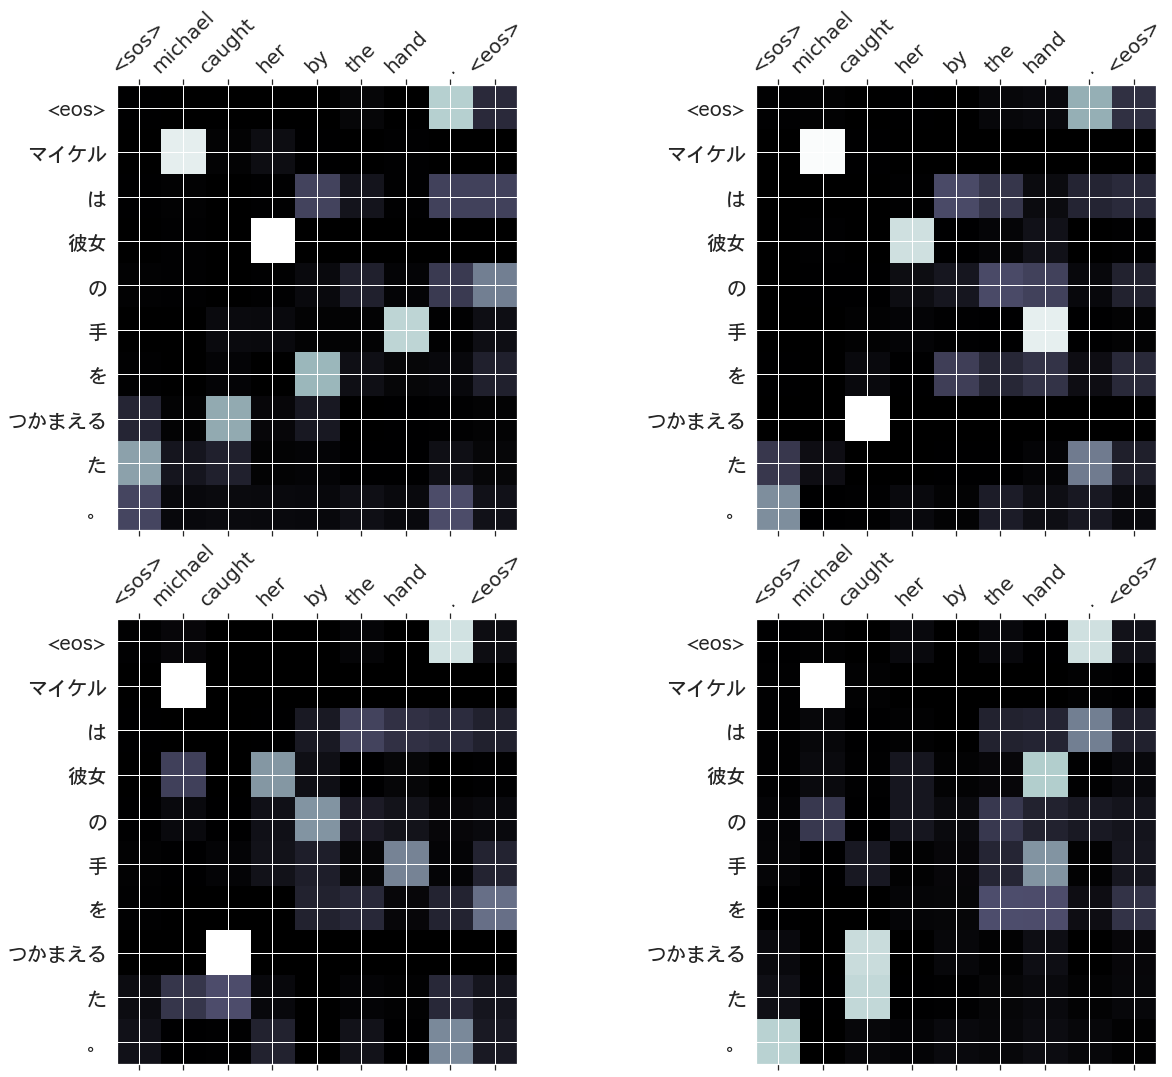

src      : he acknowledged it to be true .
trg      : 彼 は それ を 真実 だ と 認める た 。
predicted: <eos> 彼 は それ は 本当 だ と 認める た 。
     blue: 88.01%


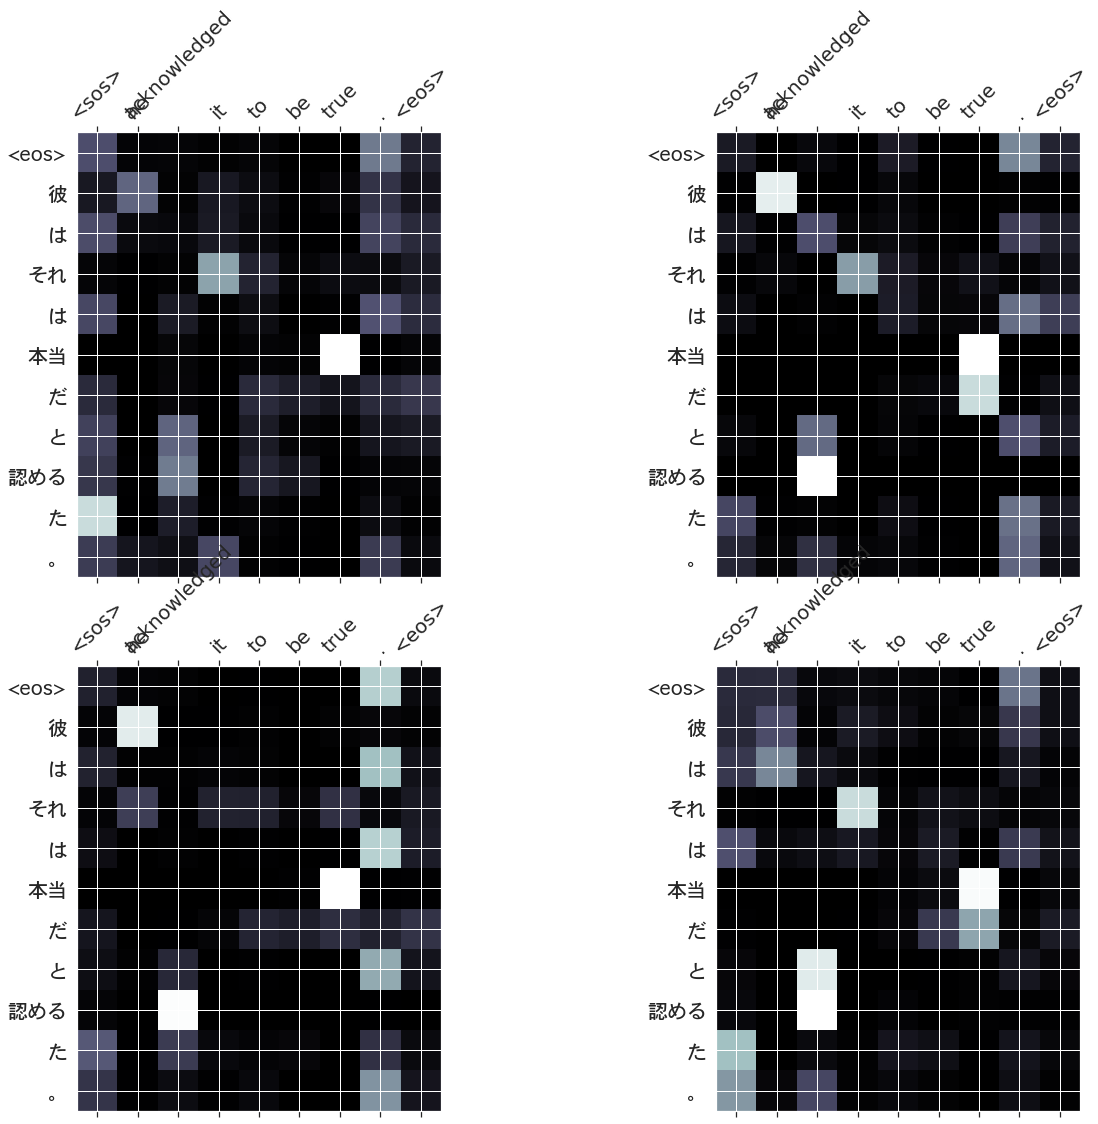

src      : the teacher told them not to swim in the river .
trg      : 先生 は 彼ら に 川 で 泳ぐ ない よう に と 言う た 。
predicted: <eos> 川 で 泳ぐ な と 彼ら に 言う た 。
     blue: 91.47%


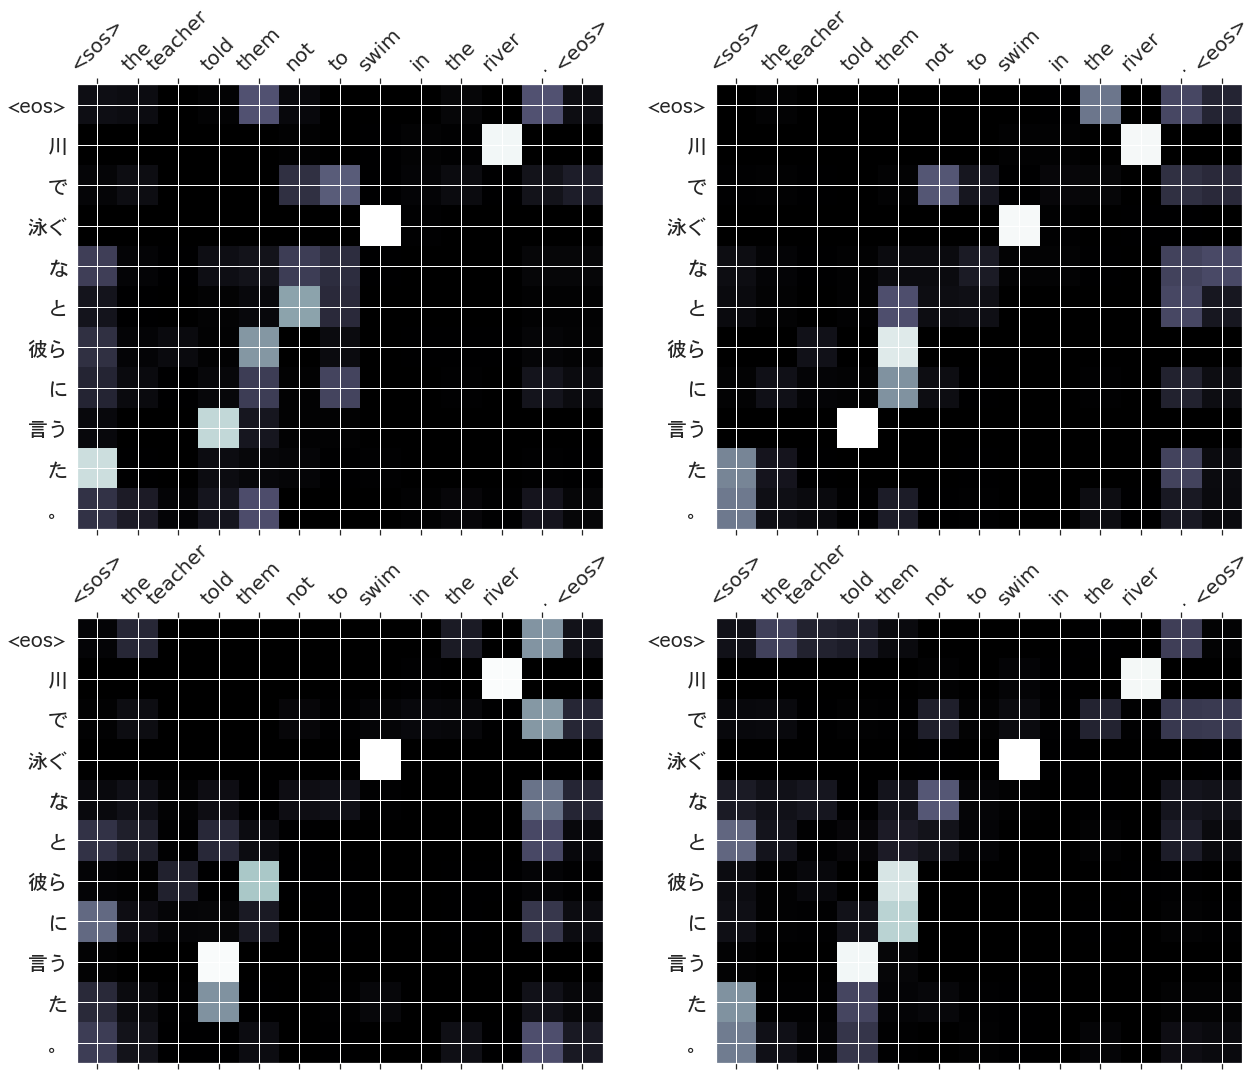

src      : she flapped at the fly with a newspaper .
trg      : 彼女 は 新聞 で ハエ を ピシャ っと たたく た 。
predicted: <eos> 彼女 は <unk> を 新聞 で <unk> た 。
     blue: 86.33%


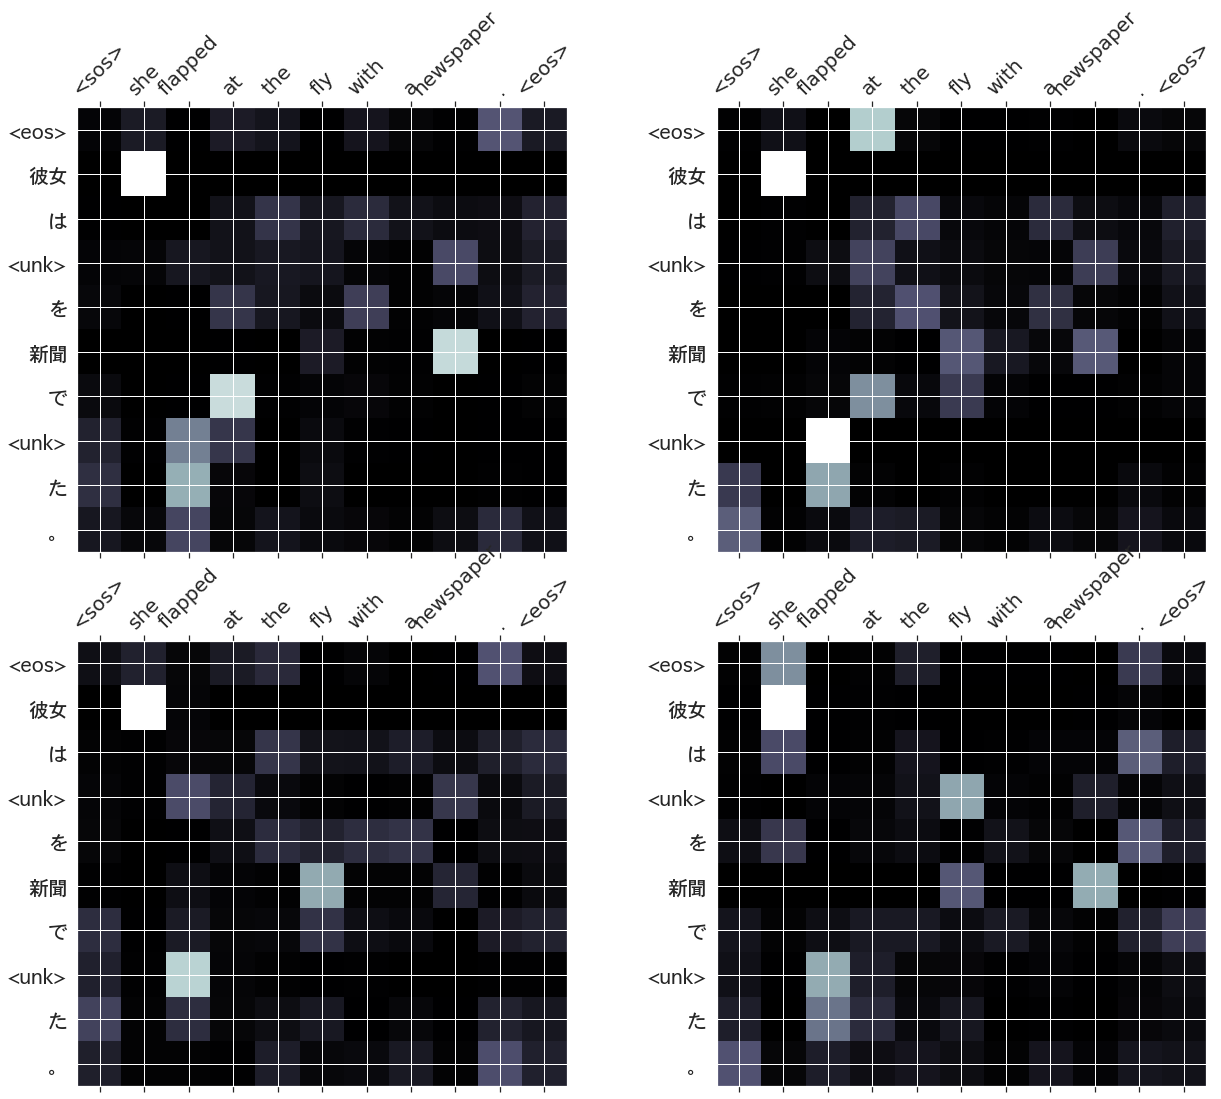

src      : birds fly in the sky .
trg      : 鳥 は 空 を 飛ぶ ます 。
predicted: <eos> 鳥 が 空 を 飛ぶ 。
     blue: 90.36%


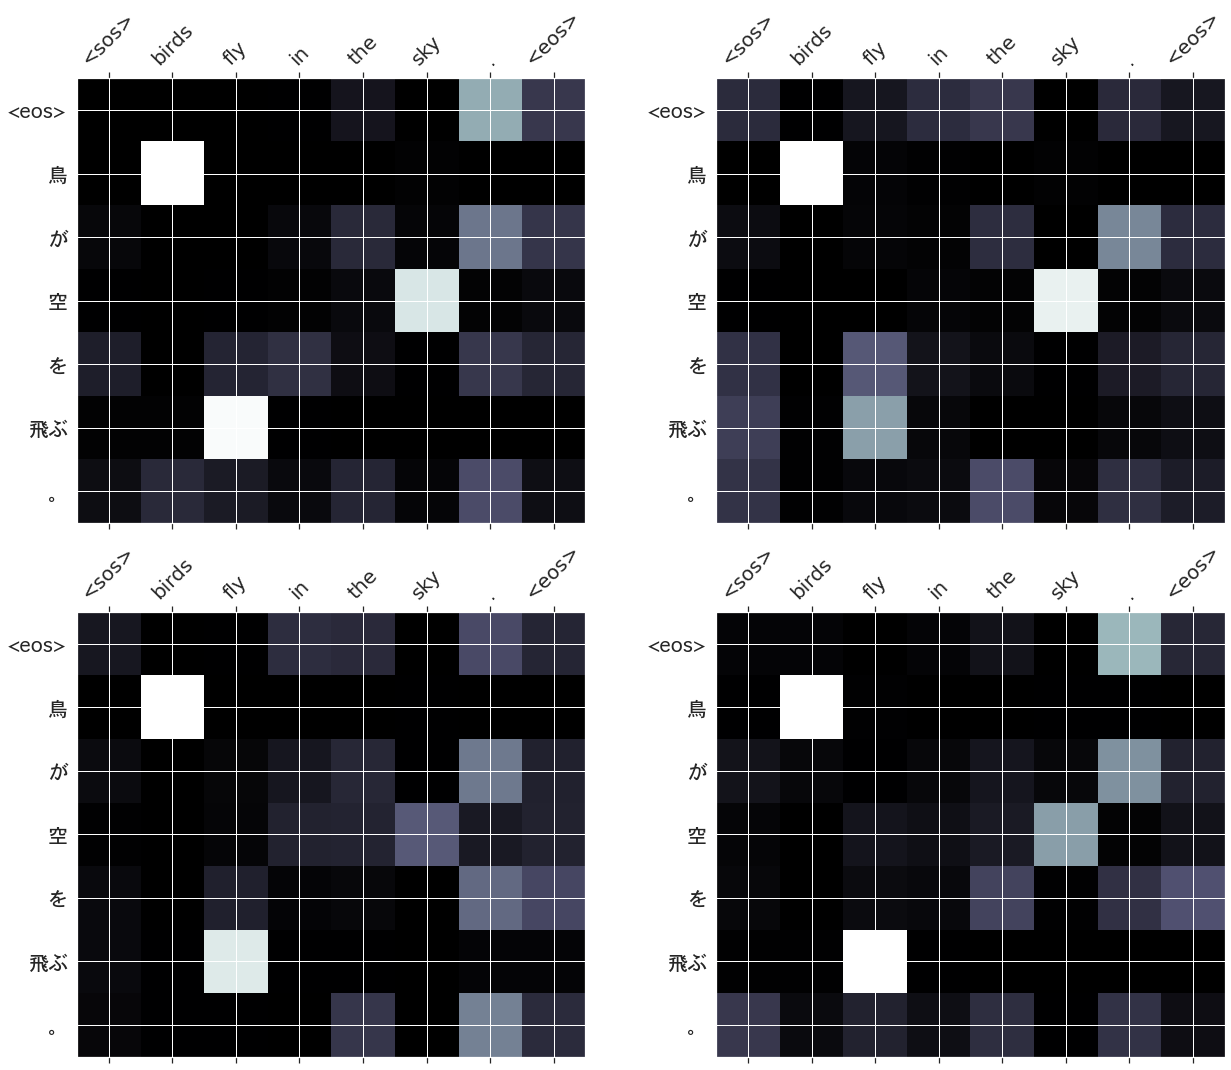

src      : i 'd like to change my seat .
trg      : 席 を 替える て ほしい の です が 。
predicted: <eos> 席 を 変える たい の です が 。
     blue: 88.91%


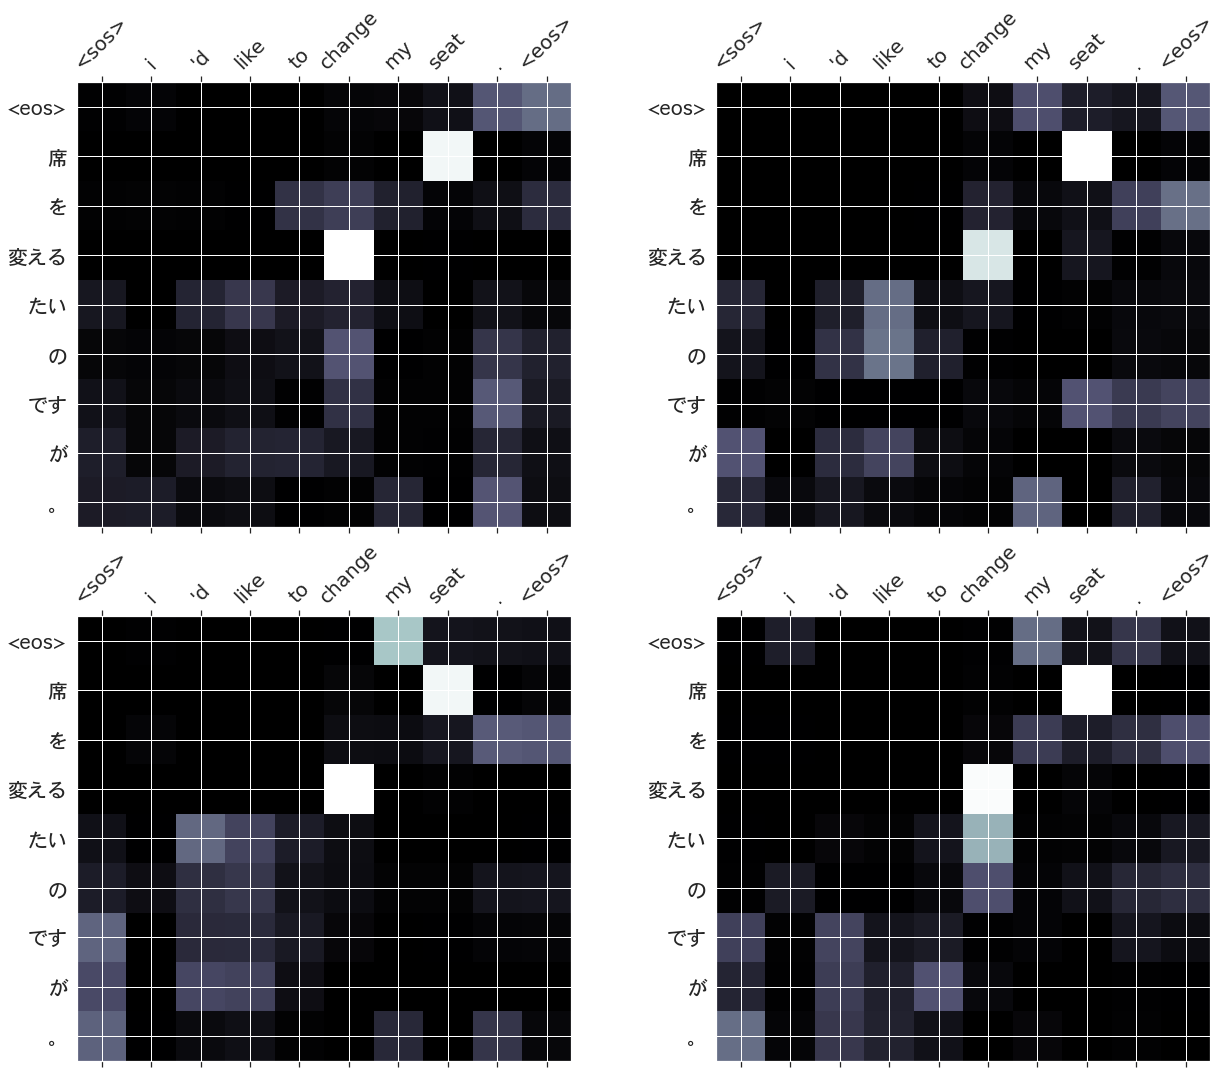

src      : we had few sunny days this summer .
trg      : 今年 の 夏 は 晴れ の 日 が ほとんど ない た 。
predicted: <eos> 今年 の 夏 は 晴れ の 日 が 少ない た 。
     blue: 89.32%


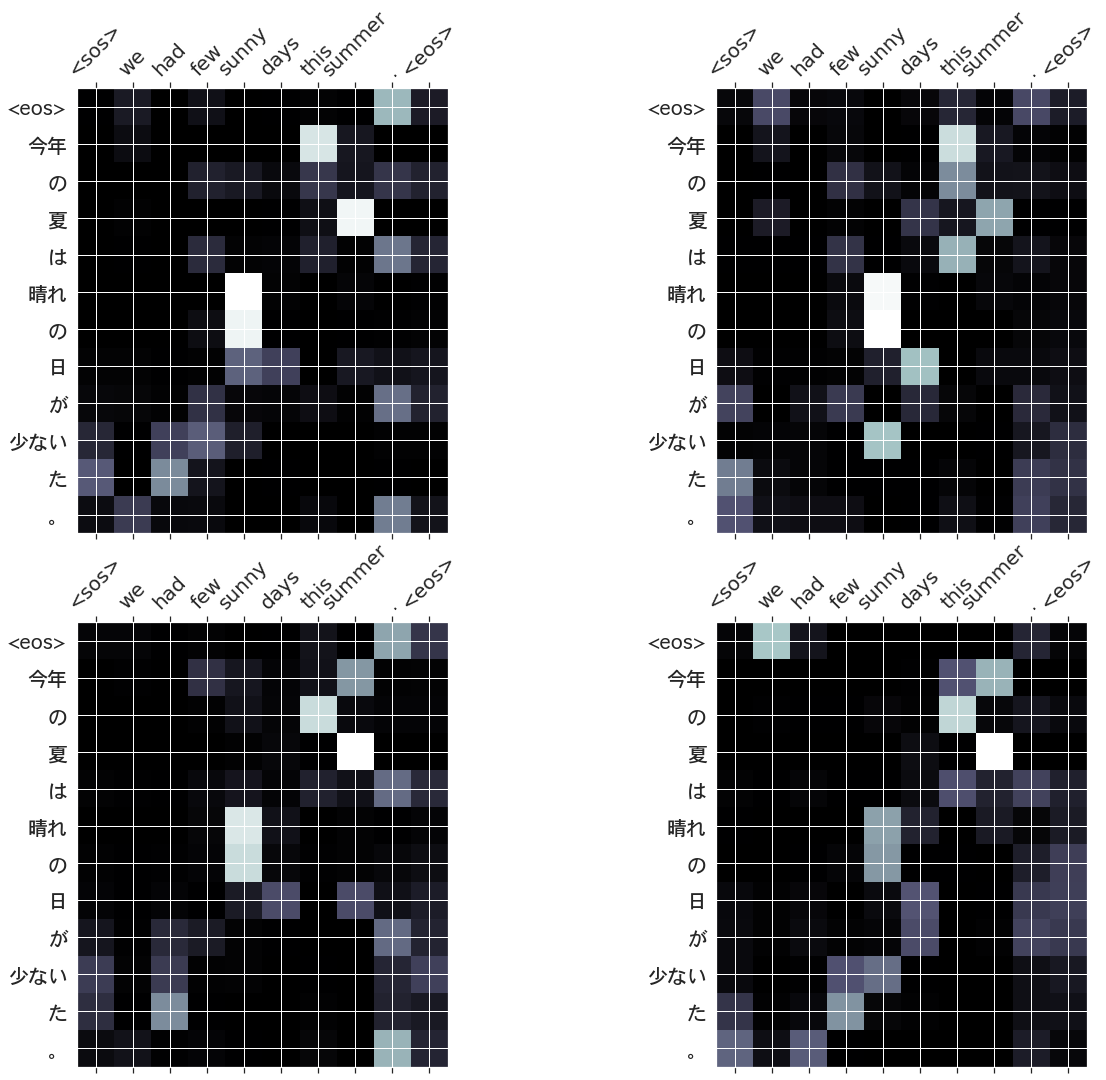

src      : plenty of people were waiting for the bus .
trg      : たくさん の 人々 が バス を 待つ て いる ます た 。
predicted: <eos> たくさん の 人々 が バス を 待つ て いる た 。
     blue: 85.94%


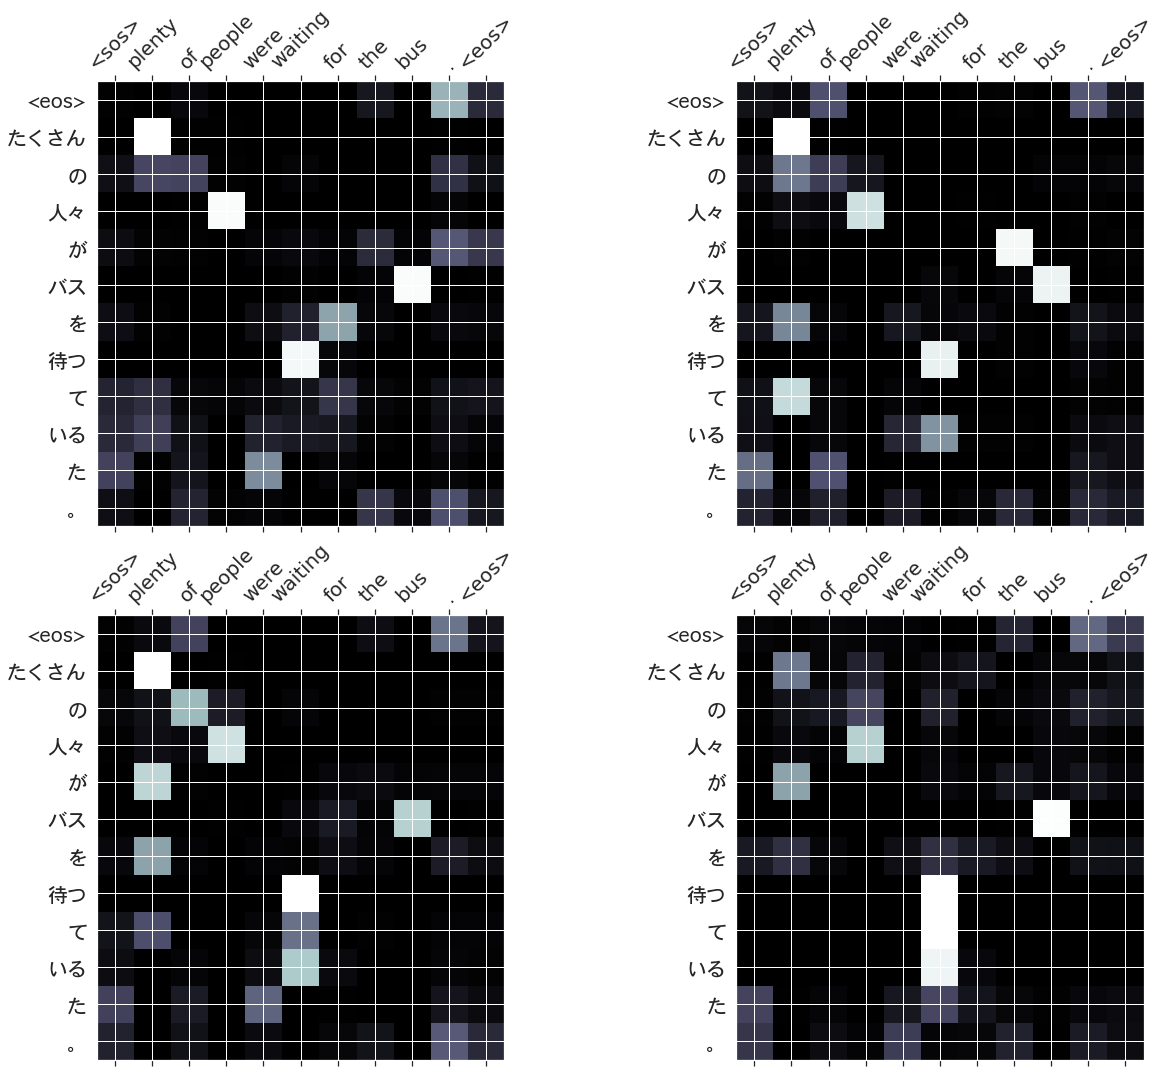

src      : she shut the door on her finger .
trg      : 彼女 は ドア に 指 を 挟む で しまう た 。
predicted: <eos> 彼女 は 指 で きっちり ドア を 閉める た 。
     blue: 88.01%


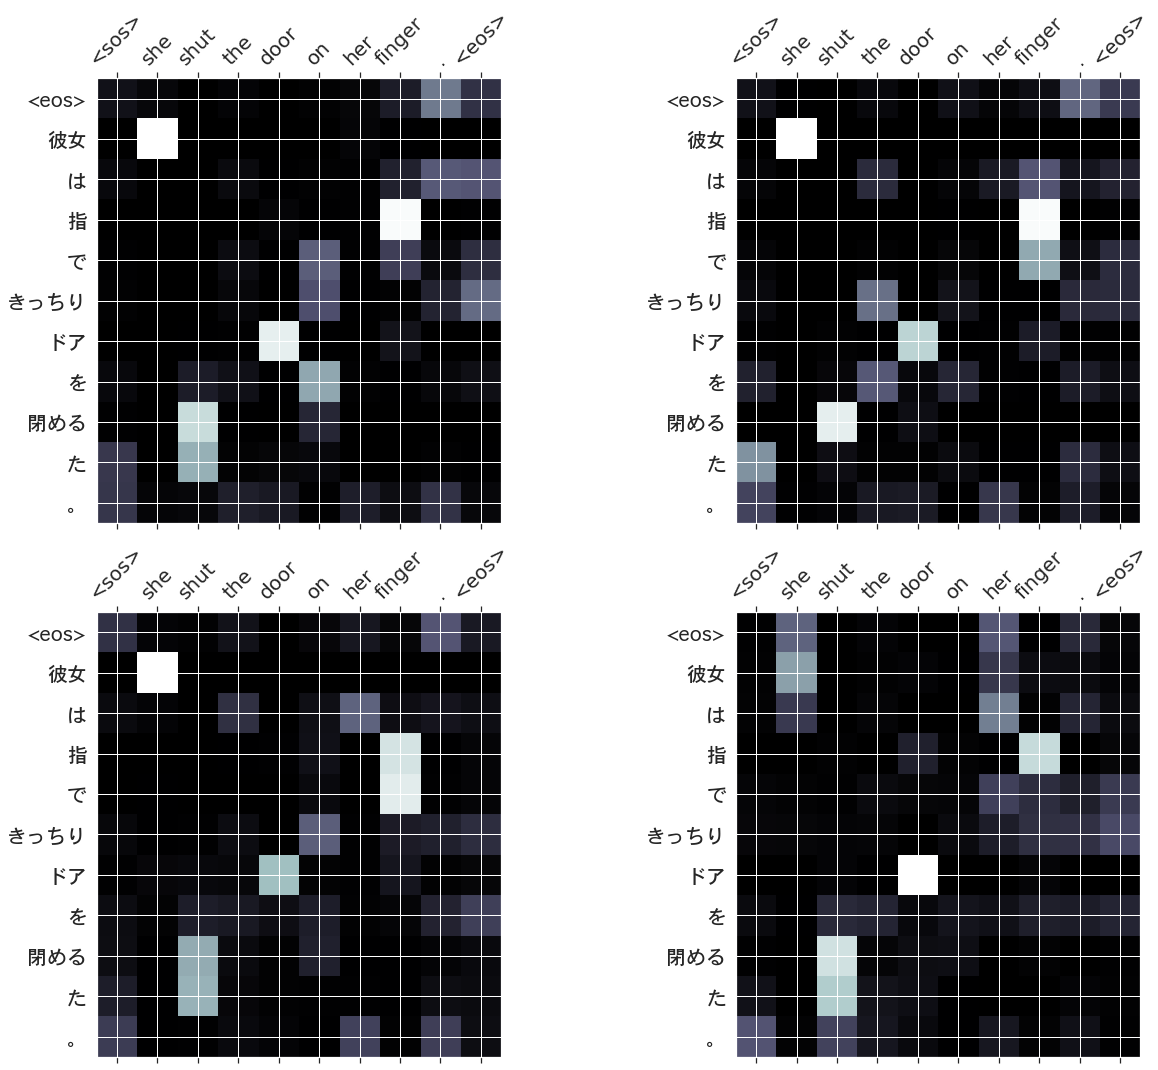

src      : waves are beating the shore .
trg      : 波 が 浜 に 打ち寄せる て いる 。
predicted: <eos> 波 が <unk> する て いる 。
     blue: 86.94%


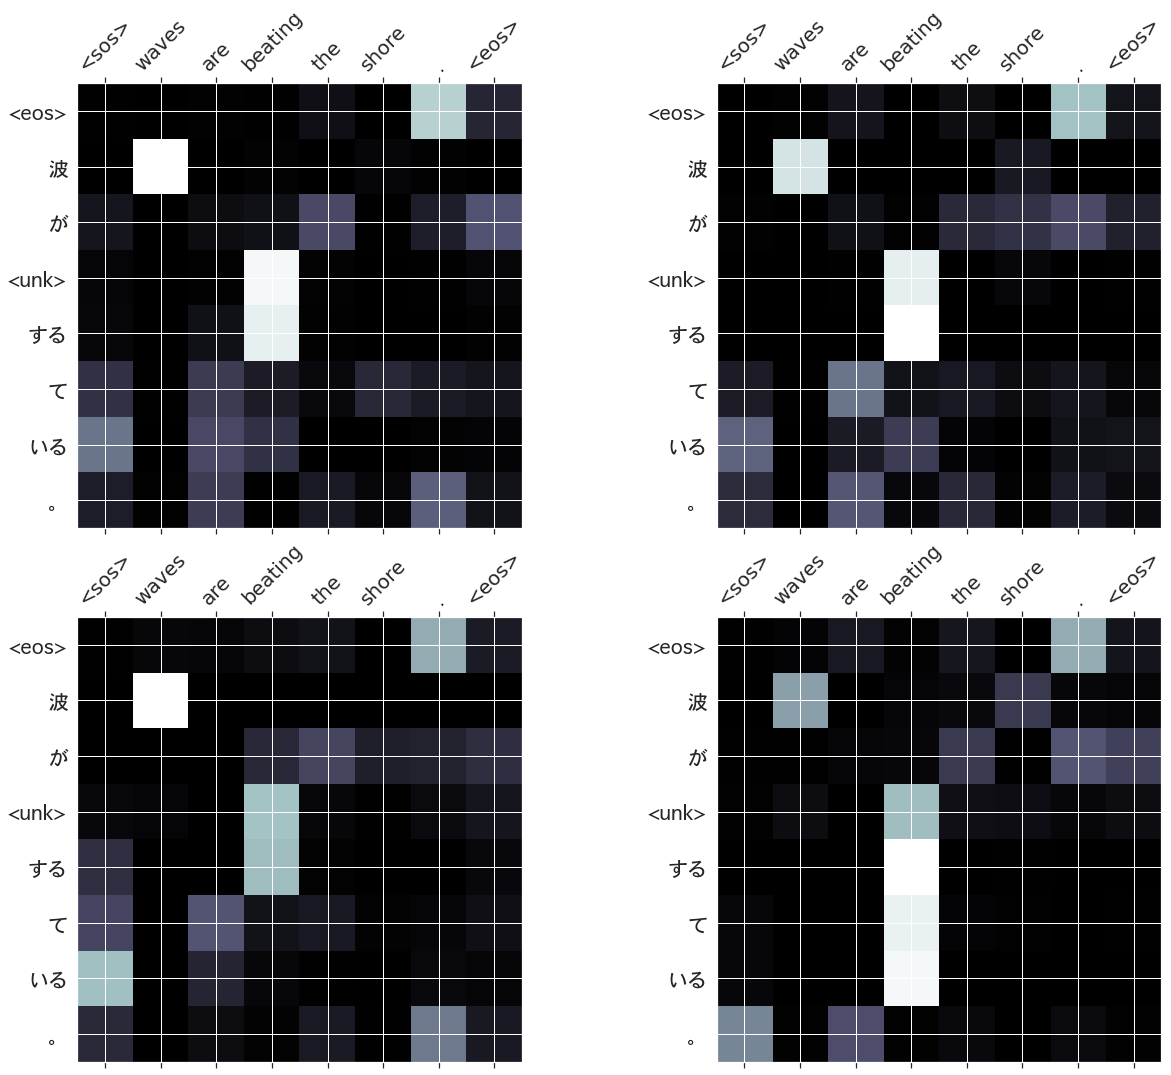

src      : i asked him where he was going .
trg      : 私 は 彼 に どこ へ 行く ところ だ の か と たずねる た 。
predicted: <eos> 私 は 彼 が どこ に いる の か と 尋ねる た 。
     blue: 91.22%


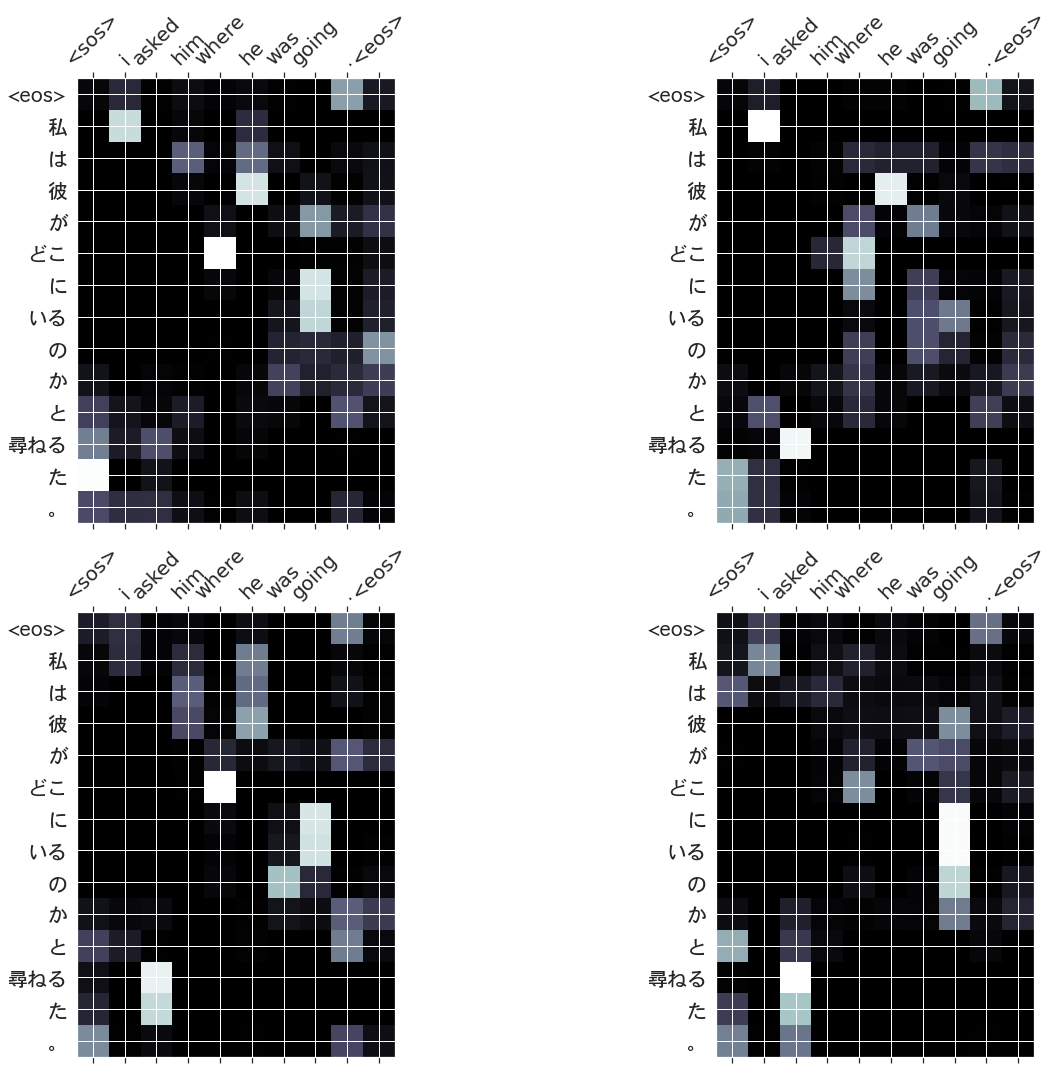

src      : i know that mary went abroad .
trg      : 私 は メアリー が 外国 へ 行く た こと を 知る て いる 。
predicted: <eos> 私 は メアリー が 外国 へ 行く た こと を 知る て いる 。
     blue: 86.94%


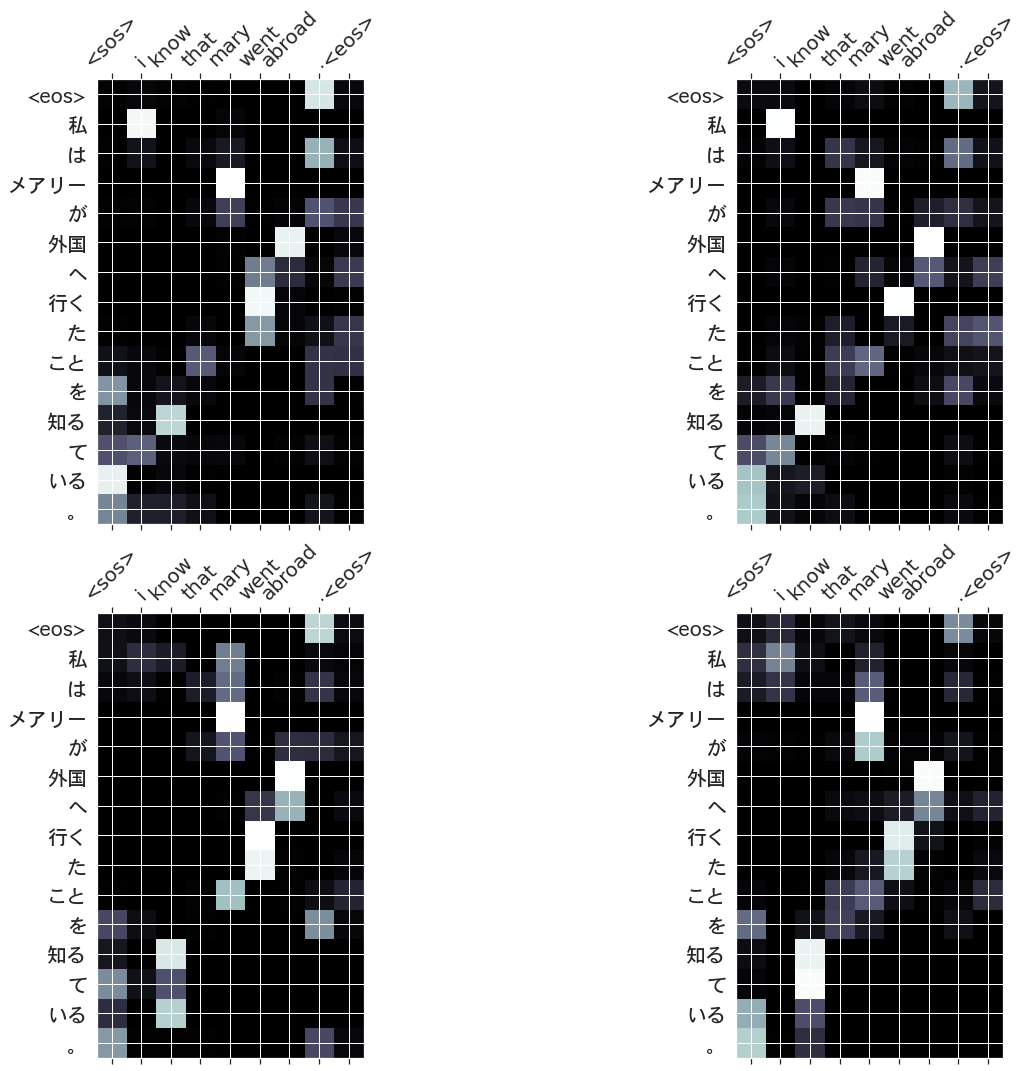

src      : his comment was concise and to the point .
trg      : 彼 の 評論 は 簡潔 で 要点 を 押さえる た もの だ た 。
predicted: <eos> 彼 の 批評 は 批評 する て 適切 だ た 。
     blue: 85.94%


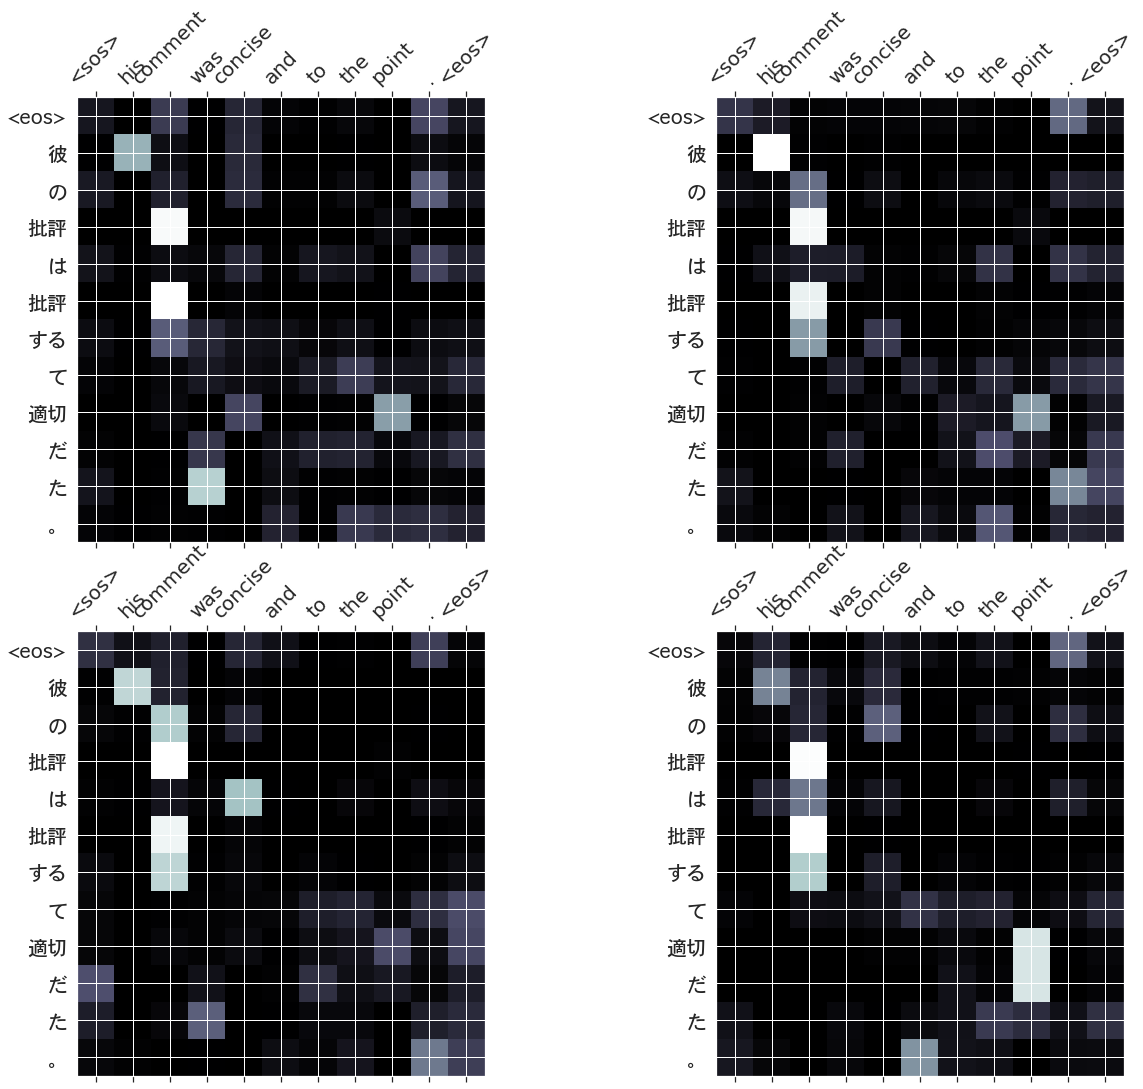

src      : he is one of the candidates running for mayor .
trg      : 彼 は 市長 に 立候補 する て いる 候補 者 の １ 人 です 。
predicted: <eos> 彼 は 市長 の 一 人 です 。
     blue: 88.91%


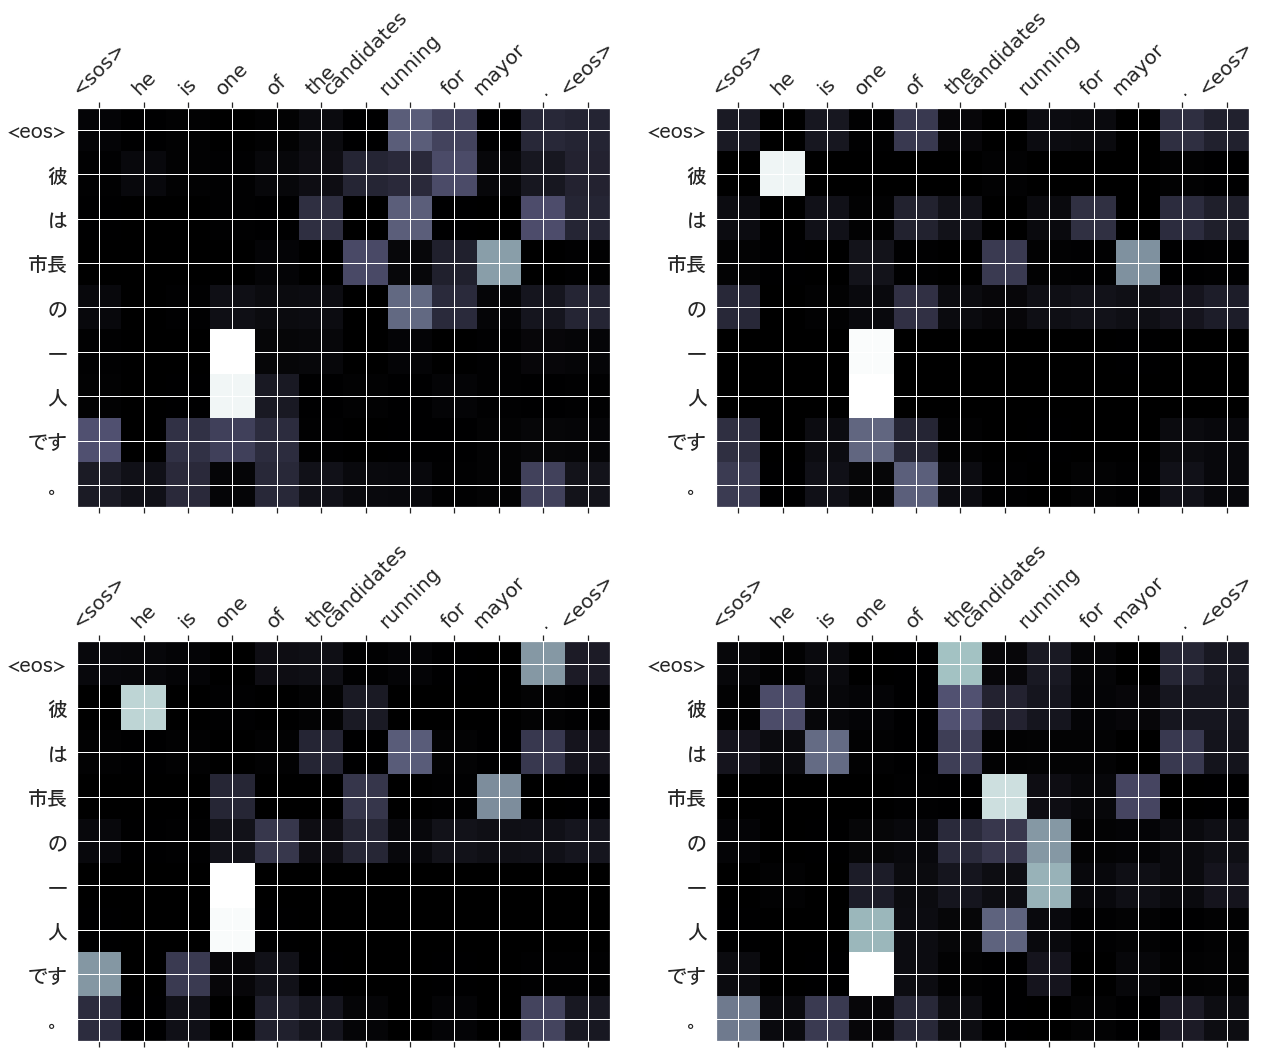

src      : the outdoor concert was canceled due to the storm .
trg      : 野外 コンサート は 嵐 の ため に 中止 に なる た 。
predicted: <eos> <unk> 会 は 嵐 の ため 中止 に なる た 。
     blue: 85.94%


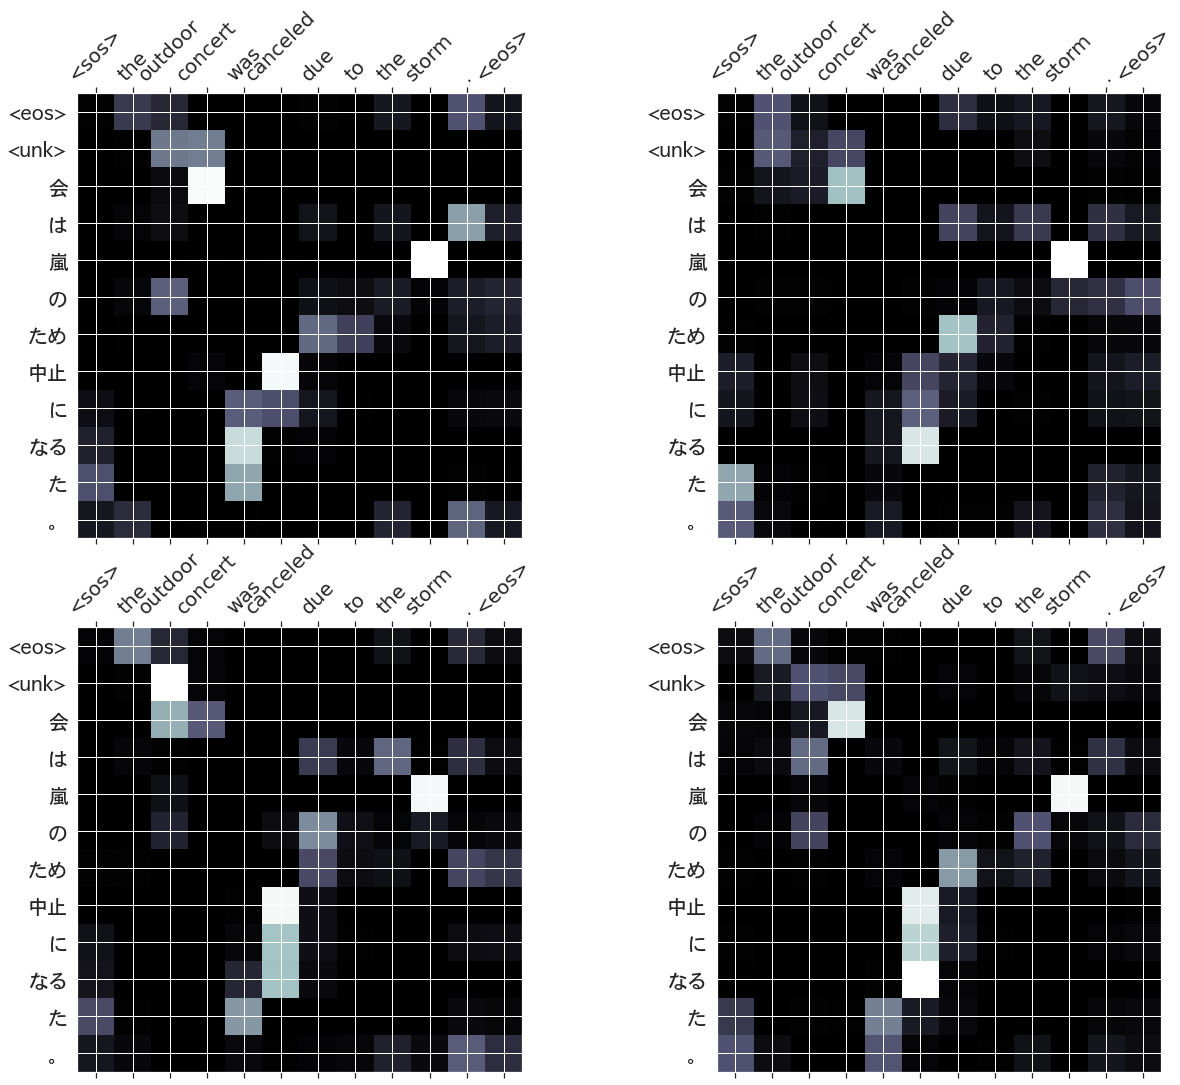

src      : we want a car .
trg      : 私 達 は 車 が 欲しい 。
predicted: <eos> 私 たち は 車 が 欲しい 。
     blue: 91.93%


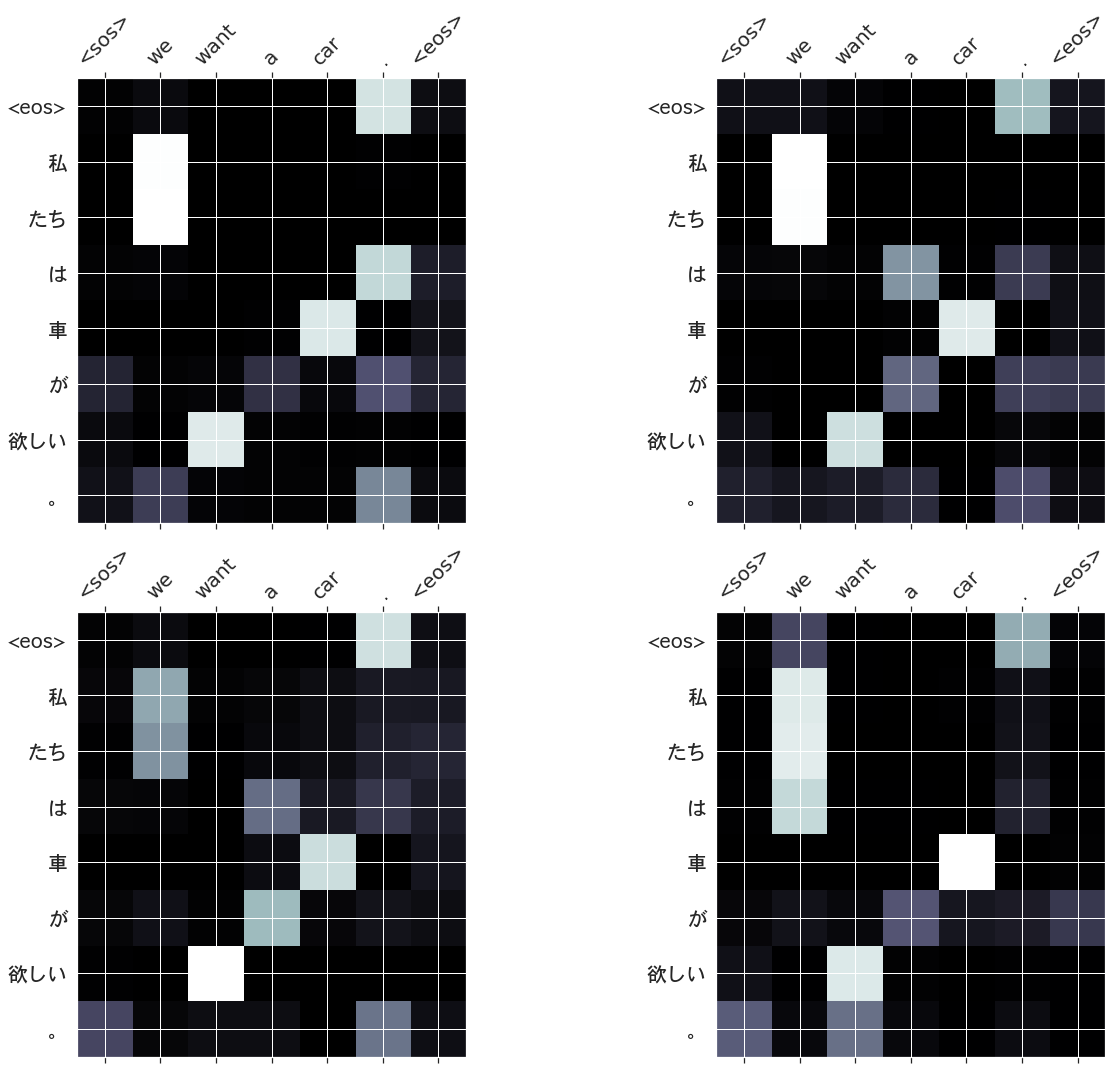

src      : in my opinion , he is wrong .
trg      : 私 の 考え で は 、 彼 は 間違う て いる 。
predicted: <eos> 私 の 考え で は 、 彼 は 間違う て いる 。
     blue: 90.36%


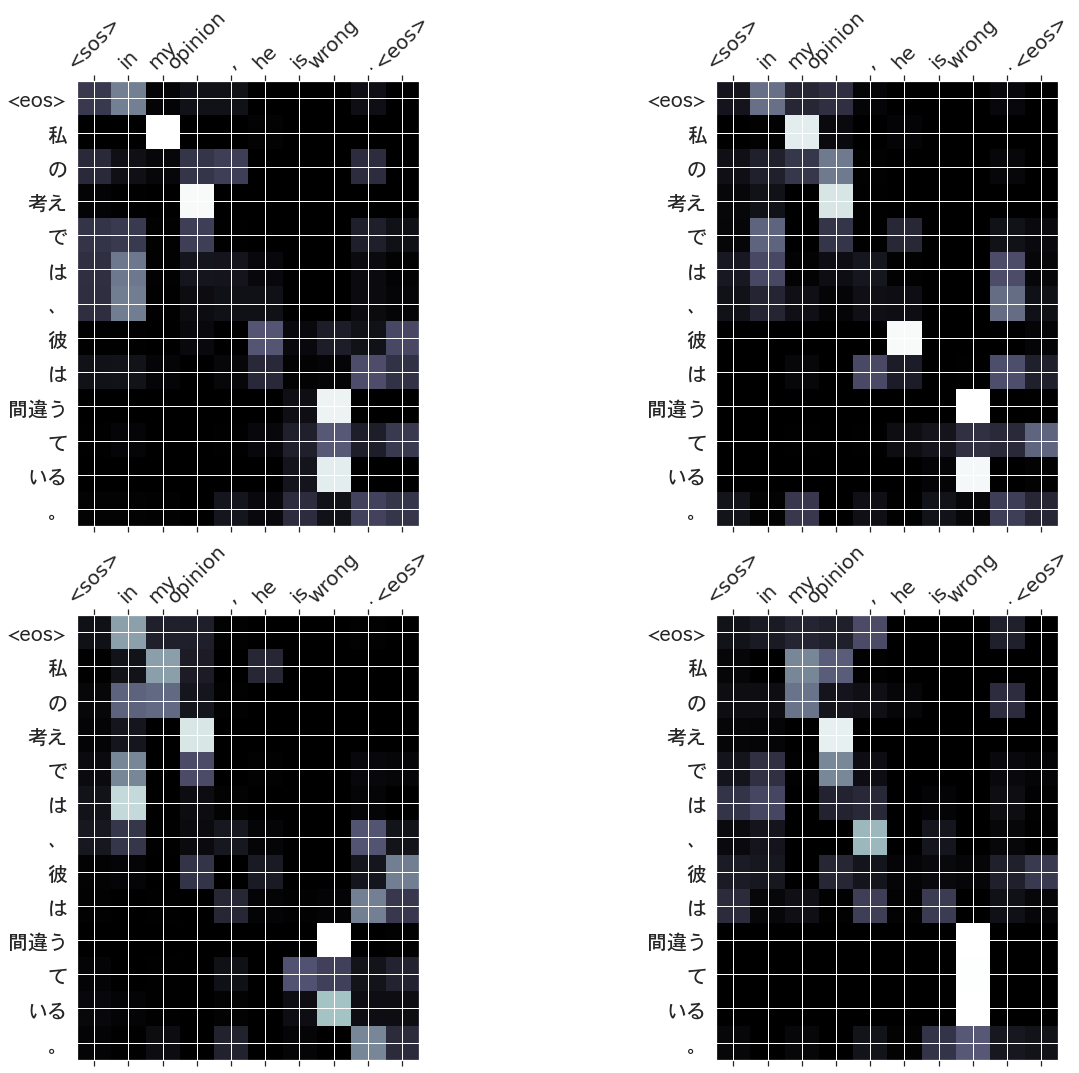

src      : he watched with the patient .
trg      : 彼 は 病人 を 寝る ぬ に 看病 する た 。
predicted: <eos> 彼 は 病人 で 病人 を 見守る た 。
     blue: 86.33%


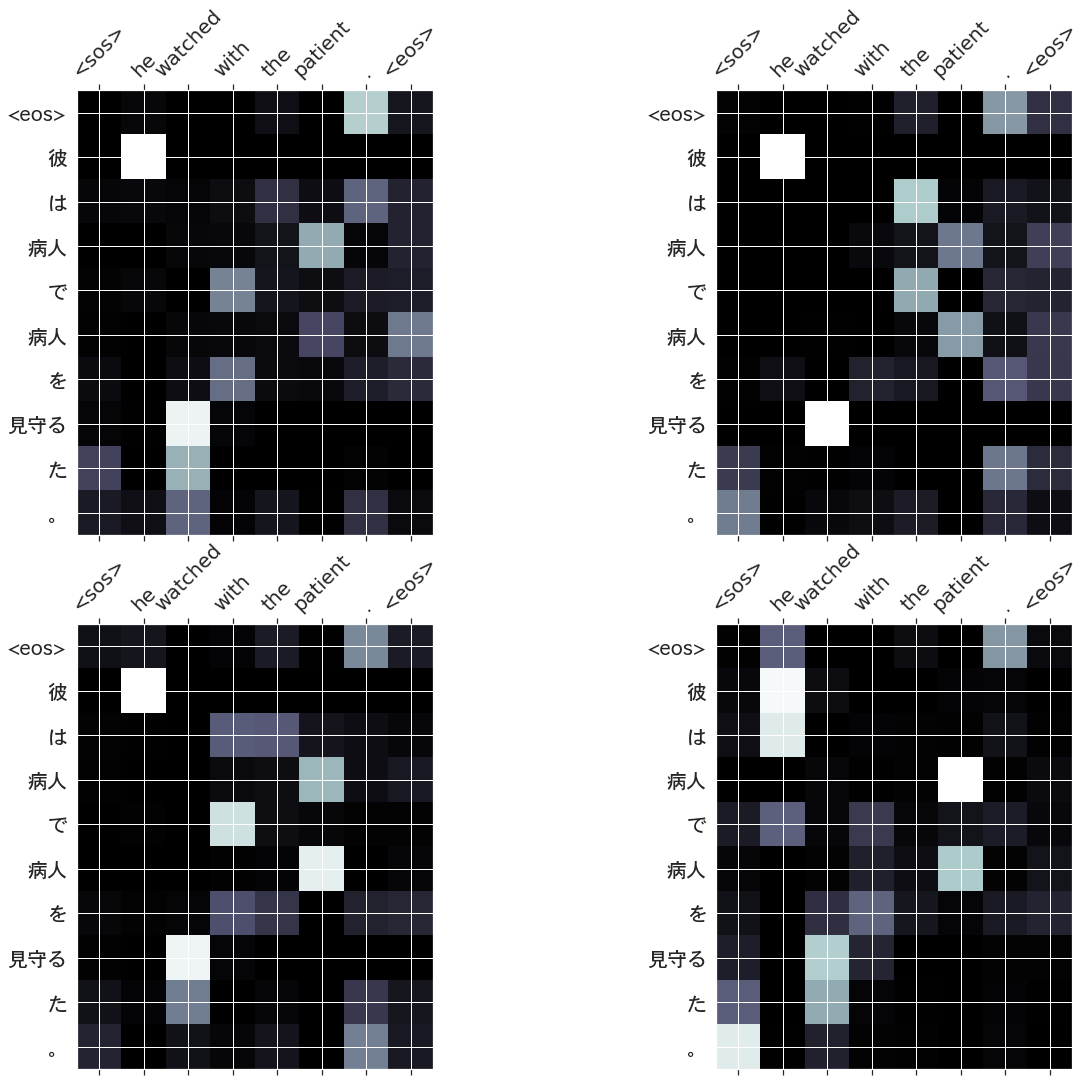

src      : i remember the house where i grew up .
trg      : 私 は 自分 の 生まれる 育つ た 家 を 覚える て いる 。
predicted: <eos> 私 は 住む で 成長 する た 家 を 覚える て いる 。
     blue: 85.66%


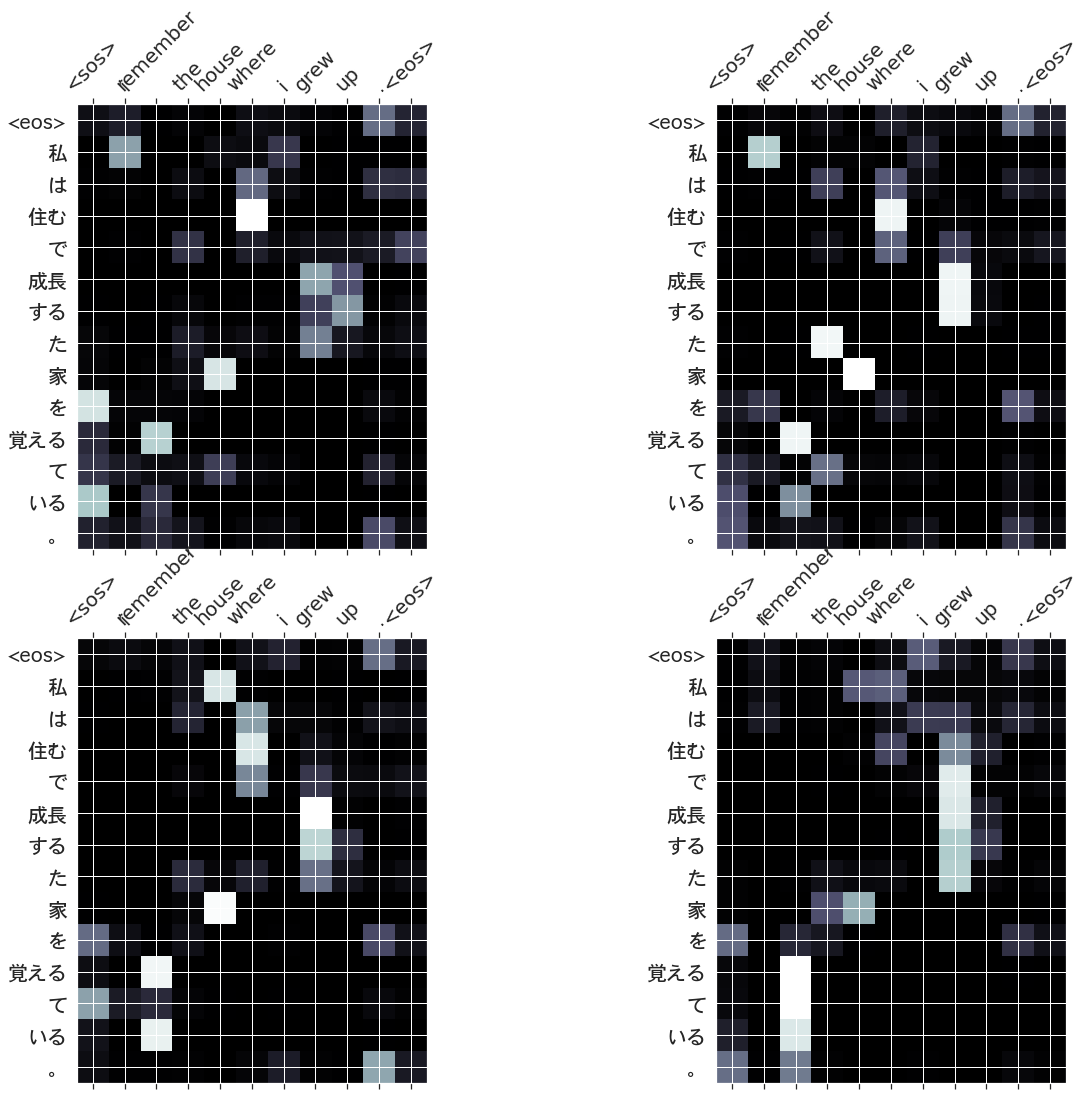

src      : this bridge bears only ten tons .
trg      : この 橋 は 重い さ １ ０ トン しか 支える られる ます ん 。
predicted: <eos> この 橋 は １ ０ トン の 重い さ しか ない 。
     blue: 87.39%


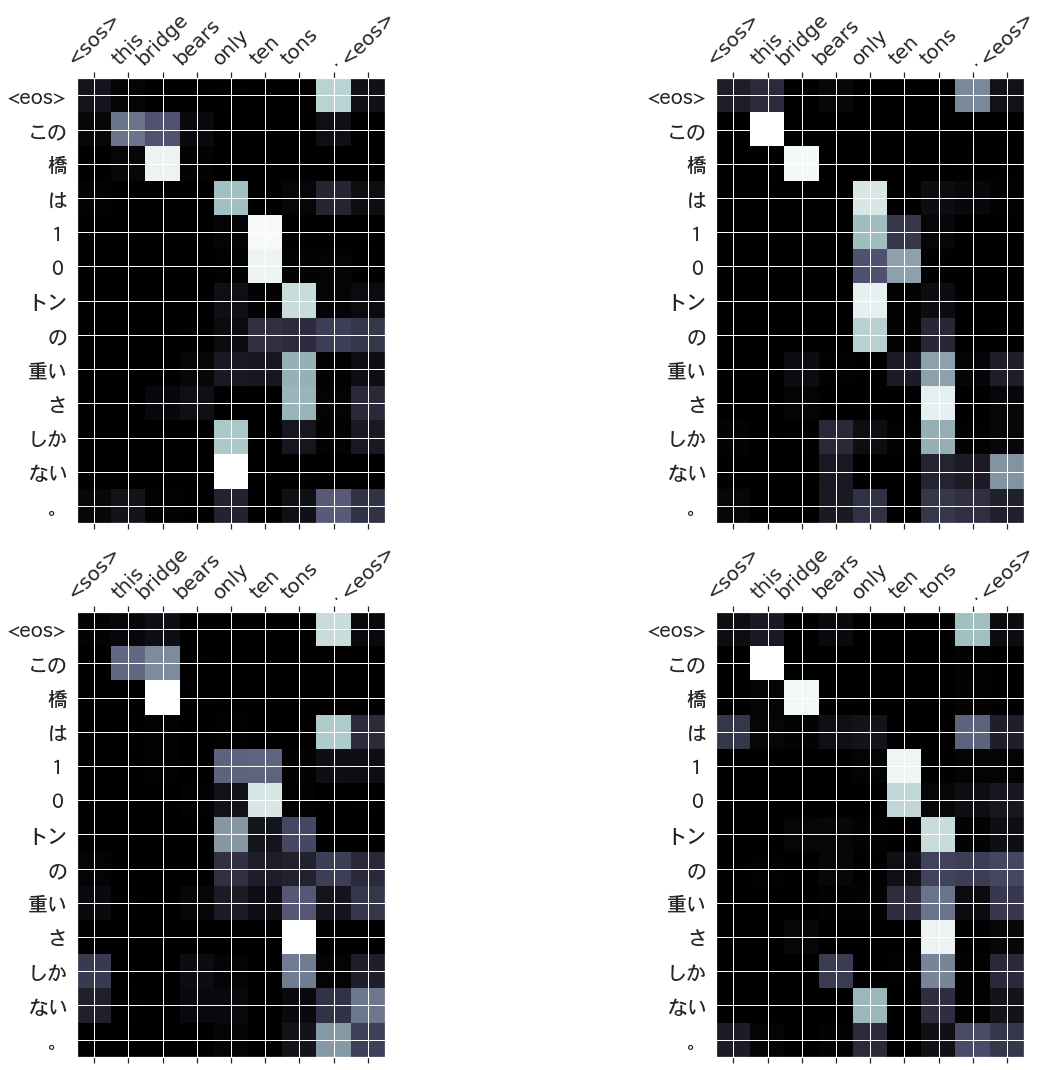

src      : i wanted something to eat .
trg      : 私 は 何 か 食べ物 が 欲しい た 。
predicted: <eos> 私 は 何 か 食べる たい た 。
     blue: 93.06%


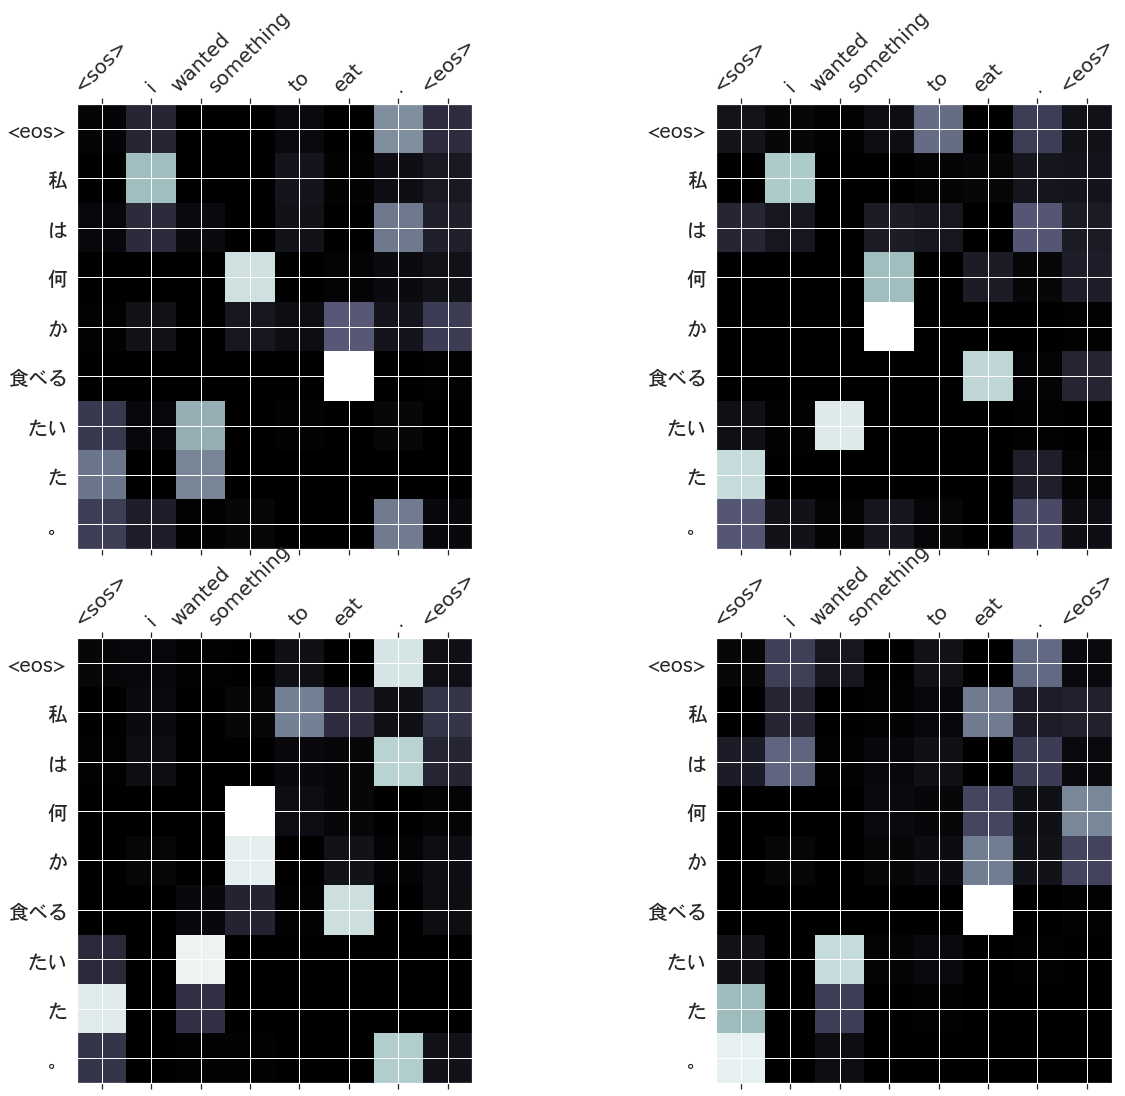

src      : his ironical remarks are n't directed at you .
trg      : 彼 の 皮肉 は 君 に 向ける られる た もの だ は ない 。
predicted: <eos> 彼 の 皮肉 は あなた に 向ける た の だ は ない 。
     blue: 85.66%


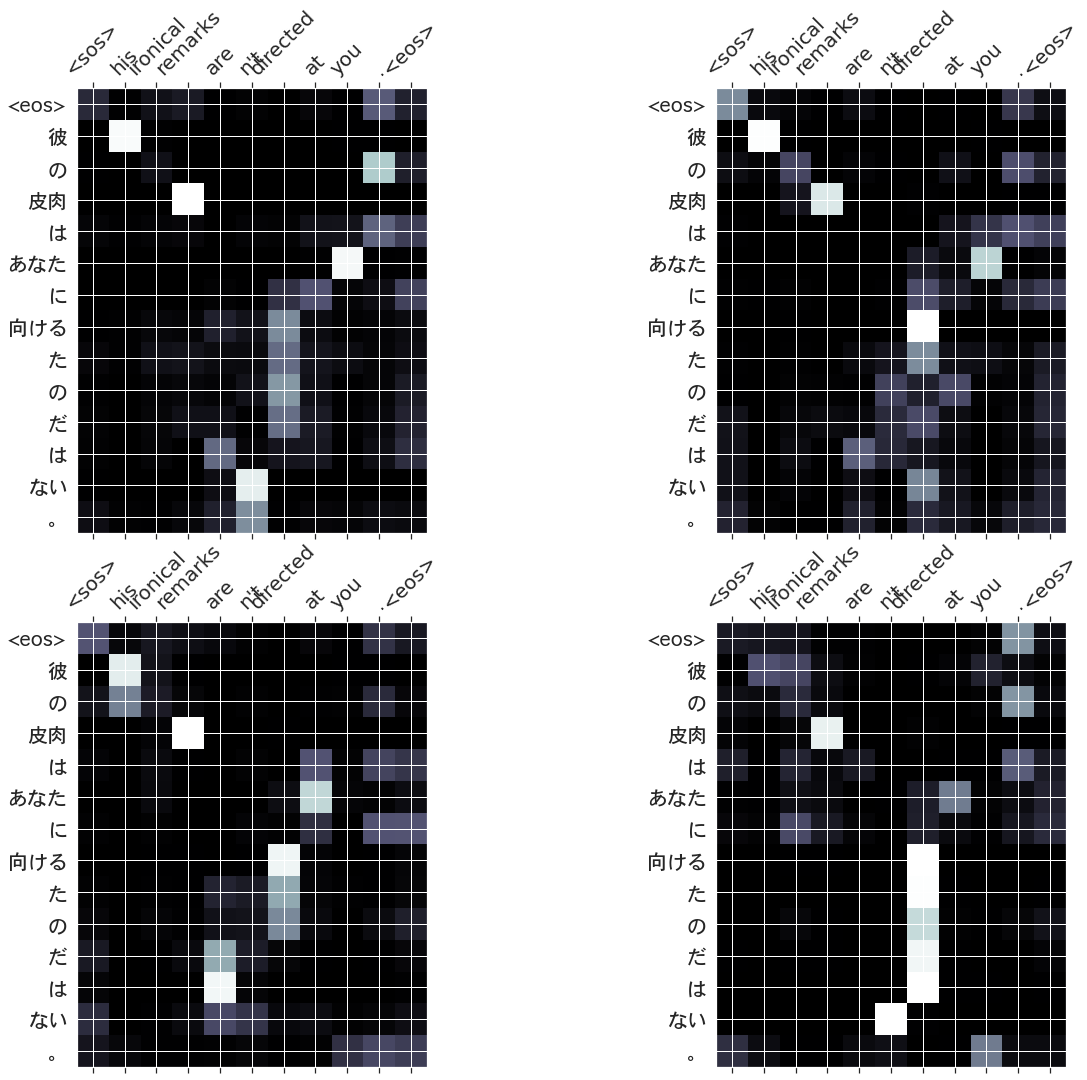

src      : they adorned the room with flowers .
trg      : 部屋 を 花 で 飾る た 。
predicted: <eos> 彼ら は 部屋 を 花 で 取り付ける た 。
     blue: 86.33%


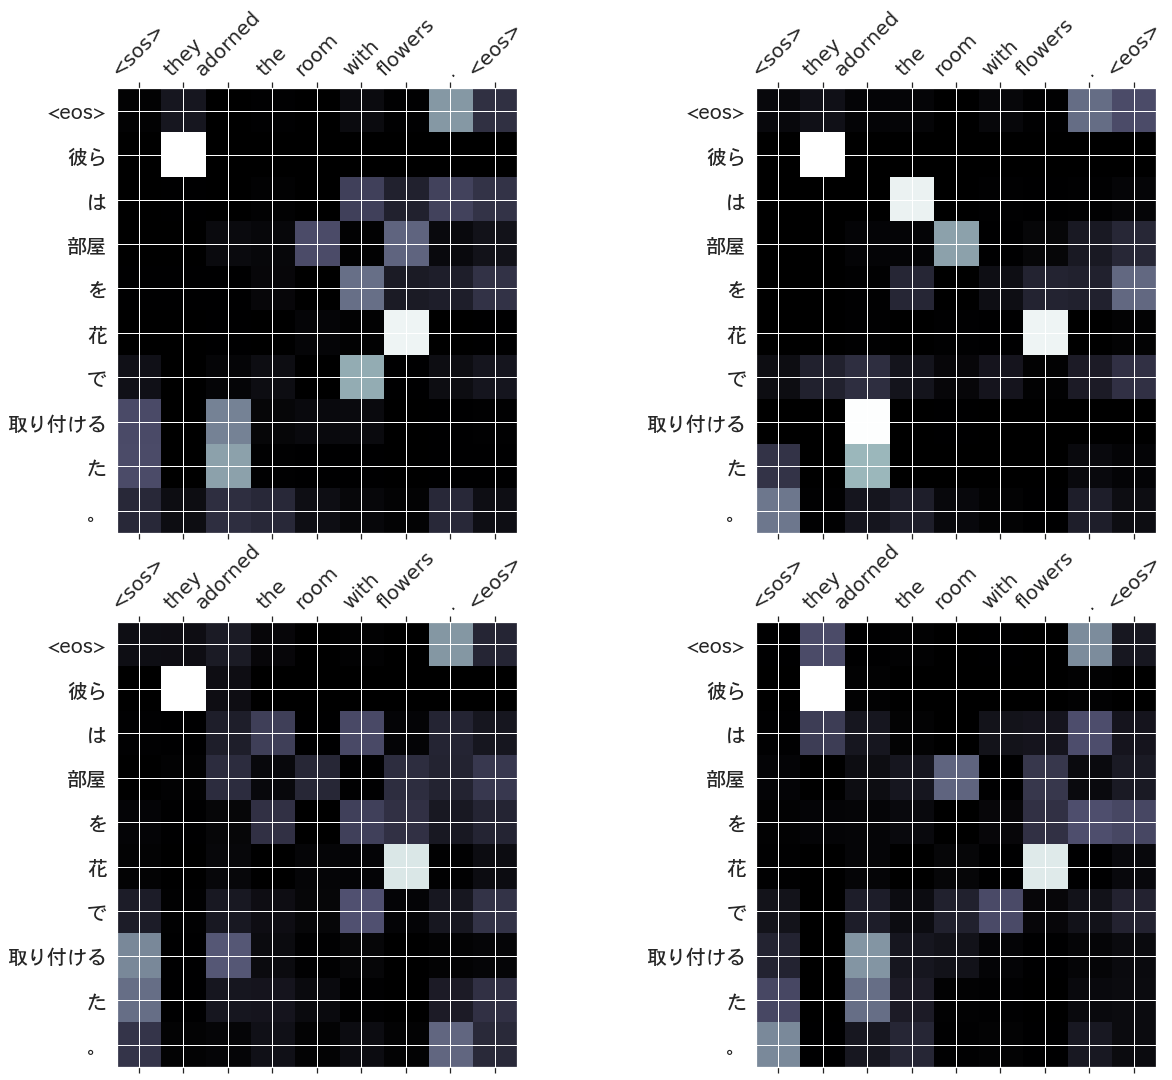

src      : when will he go home ?
trg      : 彼 は いつ 家 に 帰れる の です か 。
predicted: <eos> 彼 は いる つ 帰宅 する ます か 。
     blue: 86.33%


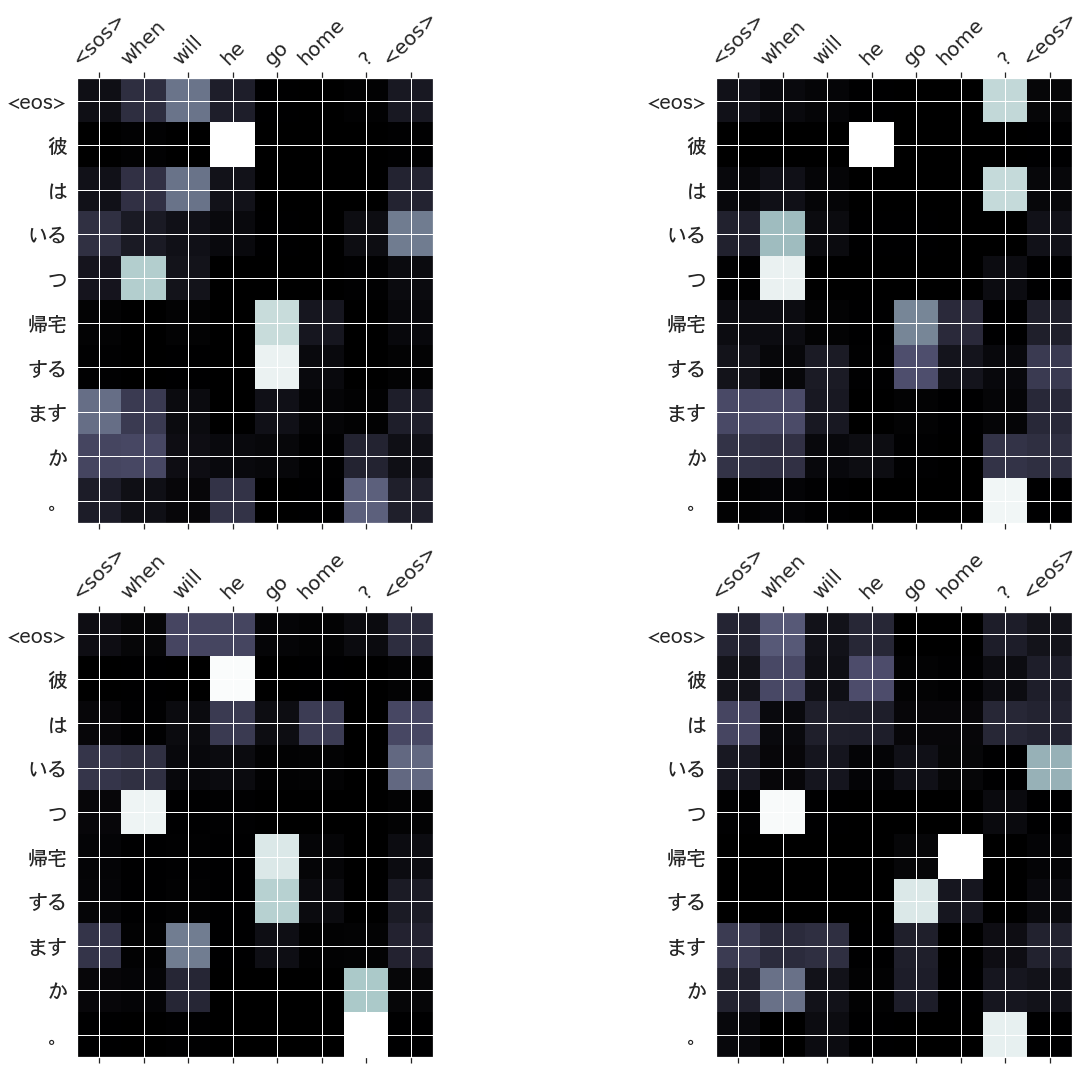

In [52]:
idxs = list(range(len(test_data)))
random.shuffle(idxs)

count = 0

for example_idx in idxs:
    example_idx = random.randint(0, 1219)
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    result = [translation[0]]
    
    blue = sentence_blue(trg, translation, 4)
    if blue < .85:
        continue


    for token in translation:
        if token != result[-1]:
            result.append(token)
    print(f'src      : {" ".join(src)}')
    print(f'trg      : {" ".join(trg[::-1])}')
    print(f'predicted: {" ".join(translation[::-1])}')
    print(f'     blue: {100 * blue:.2f}%')
    display_attention(src, translation, attention)

    count += 1
    if count > 40:
        break